In [1]:
import pandas as pd

In [2]:
df_combined = pd.read_csv('../tmp_data/df_combined_298K_compact.csv')
#get all combination of sources
sources = df_combined['source'].unique()
combinations = []
for i in range(len(sources)):
    for j in range(i+1,len(sources)):
        combinations.append([sources[i],sources[j]])
    

In [3]:
df_combined_desc = pd.read_csv('../tmp_data/df_combined_298K_descriptors.csv')


In [4]:
#to add to sandbox_utils
import matplotlib.pyplot as plt
def plot_duplicate_correlation_multiple(df,combinations):
    fig, axs = plt.subplots(1, len(combinations), figsize=(15, 15))
    for i,combination in enumerate(combinations):
        df1 = df[df['source']==combination[0]]
        df2 = df[df['source']==combination[1]]
        #get overlapping inchikeys
        inchikeys_source1 = df1['inchikey'].unique()
        inchikeys_source2 = df2['inchikey'].unique()
        inchikeys_overlap = list(set(inchikeys_source1).intersection(inchikeys_source2))
        #get duplicates
        df1_duplicates = df1[df1['inchikey'].isin(inchikeys_overlap)]
        df2_duplicates = df2[df2['inchikey'].isin(inchikeys_overlap)]
        #drop duplicates
        df1_duplicates = df1_duplicates.drop_duplicates(subset=['inchikey'])
        df2_duplicates = df2_duplicates.drop_duplicates(subset=['inchikey'])
        #sort by inchikey
        df_subset_duplicates_source1 = df1_duplicates.sort_values(by=['inchikey'])
        df_subset_duplicates_source2 = df2_duplicates.sort_values(by=['inchikey'])
        #get minimum and maximum for the plots
        minimum = min(df_subset_duplicates_source1['log10_VP_Pa'].min(), df_subset_duplicates_source2['log10_VP_Pa'].min())
        maximum = max(df_subset_duplicates_source1['log10_VP_Pa'].max(), df_subset_duplicates_source2['log10_VP_Pa'].max())
        #add subplot of correlation plot
        axs[i].scatter(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'], s=5)
        axs[i].set_xlabel(combination[0])
        axs[i].set_ylabel(combination[1])
        #make square
        axs[i].set_aspect('equal', 'box')
        #add diagonal line
        axs[i].plot([-20, 10], [-20, 10], color='black')
        #add dashed lines at 1 log unit difference
        axs[i].plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
        axs[i].plot([-21, 9], [-20, 10], color='black', linestyle='dashed')
        #add dashed lines at 2 log unit difference
        axs[i].plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
        axs[i].plot([-22, 8], [-20, 10], color='black', linestyle='dotted')
        #add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
        from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
        import numpy as np
        from scipy.stats import pearsonr, spearmanr, kendalltau
        #remove nan values
        df_subset_duplicates_source1 = df_subset_duplicates_source1.dropna()
        df_subset_duplicates_source2 = df_subset_duplicates_source2.dropna()
        #calculate metrics
        mae = mean_absolute_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
        rmse = np.sqrt(mean_squared_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa']))
        r2 = r2_score(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
        pearson = pearsonr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
        spearman = spearmanr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
        kendall = kendalltau(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
        #also get: fraction exactly the same (diff smaller then 0.01), fraction within 0.3 log unit, fraction within 1 log units and number of points with diff larger than 2 log units
        vals_1 = df_subset_duplicates_source1['log10_VP_Pa'].values
        vals_2 = df_subset_duplicates_source2['log10_VP_Pa'].values
        diff = vals_1-vals_2
        diff_abs = np.abs(diff)

        fraction_exactly_same = len(diff_abs[diff_abs<0.01])/len(diff_abs)
        fraction_within_03 = len(diff_abs[diff_abs<0.3])/len(diff_abs)
        fraction_within_1 = len(diff_abs[diff_abs<1])/len(diff_abs)
        number_larger_2 = len(diff_abs[diff_abs>2])


        #add metrics and number of points to plot
        text_box = axs[i].text(0.05, 0.95, 'MAE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nN: {} points\nPearson: {:.3f}\nSpearman: {:.3f}\nKendall: {:.3f}'.format(mae, rmse, r2, len(df_subset_duplicates_source1), pearson[0], spearman[0], kendall[0]), transform=axs[i].transAxes, verticalalignment='top')
        text_box.set_bbox(dict(facecolor='white', edgecolor='black'))                    
        #similar box in bottom right with fraction exactly the same, fraction within 0.3 log unit, fraction within 1 log units and number of points with diff larger than 2 log units
        text_box = axs[i].text(0.50, 0.05, 'Fraction exactly same: {:.2f}\nFraction within 0.3: {:.2f}\nFraction within 1: {:.2f}\nNumber larger 2: {}'.format(fraction_exactly_same, fraction_within_03, fraction_within_1, number_larger_2), transform=axs[i].transAxes, verticalalignment='bottom')
        text_box.set_bbox(dict(facecolor='white', edgecolor='black'))       
        axs[i].grid()
        #set limit
        axs[i].set_xlim(minimum-2, maximum+2)
        axs[i].set_ylim(minimum-2, maximum+2)

    plt.tight_layout()
    plt.show()
    



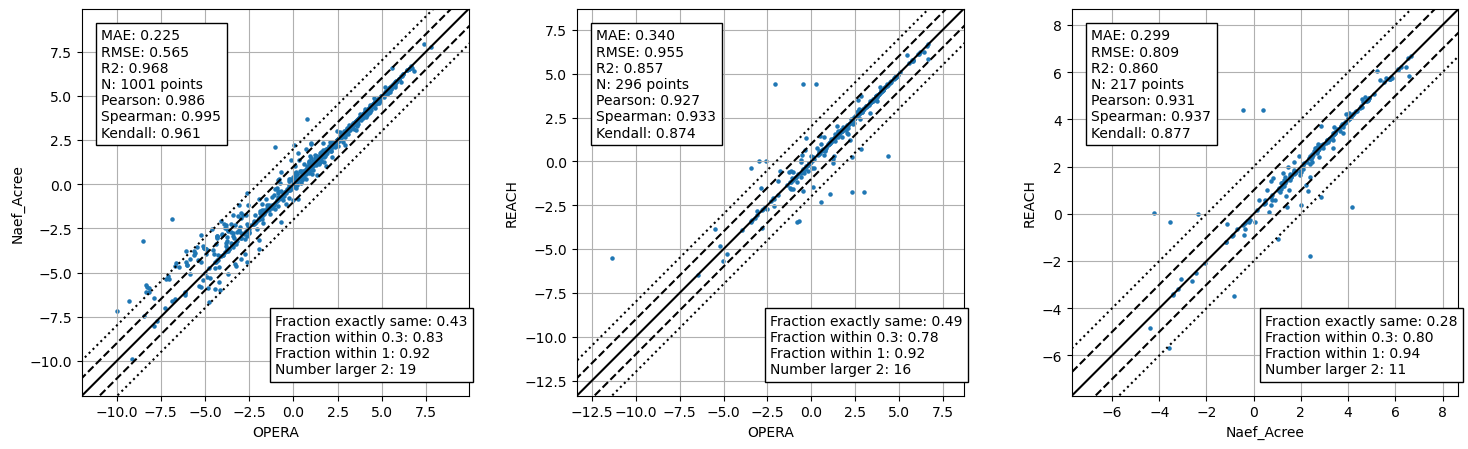

In [5]:
plot_duplicate_correlation_multiple(df_combined,combinations)

In [6]:
#wait, lets try something. can we match from COSMO-therm to experimental via the df? lets get the DF filtered for experimental values and somehow match (on inchikey?) to the unclean but standardized df
from rdkit.Chem import Descriptors
from rdkit import Chem
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

def Descriptors_to_df(df):
    mols = [Chem.MolFromSmiles(smi) for smi in df['standardized_smiles']]
    descriptors = [getMolDescriptors(m) for m in mols]
    df = df.join(pd.DataFrame(descriptors))
    return df

In [7]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
def train_pred(train_sources,pred_source,df):
    train_df = df[df['source'].isin(train_sources)]
    pred_df = df[df['source'] == pred_source]

    train_X = train_df[RDKit_feature_names]
    test_X = pred_df[RDKit_feature_names]
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)

    train_y = train_df['log10_VP_Pa']
    test_y = pred_df['log10_VP_Pa']

    dtrain = xgb.DMatrix(train_X, label=train_y)
    dtest = xgb.DMatrix(test_X, label=test_y)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        verbose_eval=False
    )

    predictions = model.predict(dtest)

    return test_y, predictions
def Dataset_Extraplotion_Train_Preds(df):
    sources = df['source'].unique()
    combinations = []
    for i in range(len(sources)):
        for j in range(i+1,len(sources)):
            combinations.append([sources[i],sources[j]])
    #add to combinations the single sources
    for source in sources:
        combinations.append([source])
    trues,preds = [],[]
    training_set_titles = []
    validation_set_titles = []
    for train_c in combinations:
        print(train_c)
        for val_c in sources:
            if val_c not in train_c:
                print(val_c)
                true,pred = train_pred(train_c,val_c,df)
                trues.append(true)
                preds.append(pred)
                training_set_titles.append(train_c)
                validation_set_titles.append(val_c)
    # Combine lists into tuples
    #make titles with train and test set
    titles = []
    for t,v in zip(training_set_titles, validation_set_titles):
        titles.append(f'Train: {t}, Test: {v}')
    combined_lists = list(zip(preds, trues, training_set_titles,validation_set_titles,titles))
    sorted_combined_lists = sorted(combined_lists, key=lambda x: x[-2])

    # Unpack the sorted tuples back into separate lists
    preds_sorted, trues_sorted, training_set_titles_sorted,validation_set_titles_sorted,titles_sorted = zip(*sorted_combined_lists)

    # Print the sorted lists
    print("Sorted list1:", list(validation_set_titles_sorted))

    #return sorted lists
    return preds_sorted, trues_sorted, training_set_titles_sorted,validation_set_titles_sorted,titles_sorted


In [8]:
from sandbox_utils import *
def density_plot_multiple_custom_cross(reals, predictions, bounds=None, titles=None,global_title=None,name=None):
    num_plots = len(reals)
    print(f'making {num_plots} plots')
    num_cols = min(num_plots, 3)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed for the grid
    #if you cant devide by 3, but can divide by 2, do two rows
    if num_plots % 3 != 0 and num_plots % 2 == 0:
        num_rows = 2
        num_cols = 2   
    if num_plots == 4:
        num_rows = 2
        num_cols = 2
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D
    
    for i in range(num_plots):
        print(f'plot {i+1} of {num_plots}')
        real = reals[i]
        prediction = predictions[i]
        RMSE, MAE, EBO, KT = getStatValues_v2(real, prediction)  
                                             
        print(f'{len(real)} points')
        
        ax = axes[i]
        
        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]
        
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')
        dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")
        ax.axis([lower, upper, lower, upper])
        # ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMAE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', transform=ax.transAxes, fontsize=10, verticalalignment='top')
        text_box = ax.text(0.05, 0.25, f'RMSE: {RMSE:.2f} \nMAE: {MAE:.2f}\nFraction errors < 1: {EBO:.2f}\nKendalls Tau: {KT:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        
        if titles is not None and len(titles) > i:
            ax.set_title(titles[i], fontsize=14)
        ax.set_aspect('equal', 'box')
    
    # Remove any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    if global_title is not None:
        fig.suptitle(global_title, fontsize=16)
    
    # plt.tight_layout()
    if name:
        plt.savefig(name+'.png', dpi=600)
    plt.show()

In [9]:
df_combined_desc
#sort by inchikey
df_combined_desc_copy = df_combined_desc.sort_values(by=['inchikey'])
df_combined_desc_copy

standardized_smiles  log10_VP_Pa  \
2230                      c1ccc(C(c2ccccc2)c2ccccc2)cc1    -3.128498   
3411                         CSc1nc(NC(C)C)nc(NC(C)C)n1    -3.770000   
3410                         CSc1nc(NC(C)C)nc(NC(C)C)n1    -3.781698   
3940  CC(C)(c1ccccc1)c1ccc(OP(=O)(Oc2ccccc2)Oc2ccccc...    -8.763000   
3023                                  OC1CCCCC1c1ccccc1     0.689602   
...                                                 ...          ...   
2758                       CCCCCCCCCCCCCCCCCCCCCCCCCCCC    -6.497000   
2646                                           COCC(C)C     4.449203   
2647                                           COCC(C)C     4.440000   
4290                        COc1c(O)c(OC)c(Cl)c(Cl)c1Cl    -1.114000   
4477                                      CCCCCOC(=O)CO     1.161000   

                         inchikey      source  MaxAbsEStateIndex  \
2230  AAAQKTZKLRYKHR-UHFFFAOYSA-N       OPERA           2.199074   
3411  AAEVYOVXGOFMJO-UHFFFAOYSA-N  Naef_Acree           4.303889   
3410  AAEVYOVXGOFMJO-UHFFFAOYSA-N       OPERA           4.303889   
3940  AAHYHBHESZMGBO-UHFFFAOYSA-N  Naef_Acree          13.558047   
3023  AAIBYZBZXNWTPP-UHFFFAOYSA-N       OPERA           9.822373   
...                           ...         ...                ...   
2758  ZYURHZPYMFLWSH-UHFFFAOYSA-N  Naef_Acree           2.304287   
2646  ZYVYEJXMYBUCMN-UHFFFAOYSA-N       OPERA           4.803241   
2647  ZYVYEJXMYBUCMN-UHFFFAOYSA-N  Naef_Acree           4.803241   
4290  ZZCSBXFJFLSDRR-UHFFFAOYSA-N  Naef_Acree           9.597377   
4477  ZZRQJJJPUWSDBN-UHFFFAOYSA-N  Naef_Acree          10.302731   

      MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed    MolWt  \
2230        2.199074           0.308889        0.308889  0.576695  244.337   
3411        4.303889           0.309265        0.309265  0.770836  241.364   
3410        4.303889           0.309265        0.309265  0.770836  241.364   
3940       13.558047           0.189917       -3.998891  0.261793  444.467   
3023        9.822373           0.114676       -0.114676  0.697179  176.259   
...              ...                ...             ...       ...      ...   
2758        2.304287           1.374314        1.374314  0.134973  394.772   
2646        4.803241           0.675926        0.675926  0.493897   88.150   
2647        4.803241           0.675926        0.675926  0.493897   88.150   
4290        9.597377           0.039738       -0.269074  0.825682  257.500   
4477       10.302731           0.437731       -0.531386  0.458737  146.186   

      ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  \
2230  ...           0             0           0                  0   
3411  ...           1             0           0                  0   
3410  ...           1             0           0                  0   
3940  ...           0             0           0                  0   
3023  ...           0             0           0                  0   
...   ...         ...           ...         ...                ...   
2758  ...           0             0           0                  0   
2646  ...           0             0           0                  0   
2647  ...           0             0           0                  0   
4290  ...           0             0           0                  0   
4477  ...           0             0           0                  0   

      fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  \
2230             0            0            0             0                 0   
3411             0            0            0             0                 0   
3410             0            0            0             0                 0   
3940             0            0            0             0                 0   
3023             0            0            0             0                 0   
...            ...          ...          ...           ...               ...   
2758            

In [10]:
preds_sorted, trues_sorted, training_set_titles_sorted,validation_set_titles_sorted,titles_sorted = Dataset_Extraplotion_Train_Preds(df_combined_desc)

['OPERA', 'Naef_Acree']
REACH
['OPERA', 'REACH']
Naef_Acree
['Naef_Acree', 'REACH']
OPERA
['OPERA']
Naef_Acree
REACH


KeyboardInterrupt: 

making 9 plots
plot 1 of 9
2071 points
plot 2 of 9
2071 points
plot 3 of 9
2071 points
plot 4 of 9
2368 points
plot 5 of 9
2368 points
plot 6 of 9
2368 points
plot 7 of 9
1124 points
plot 8 of 9
1124 points
plot 9 of 9
1124 points


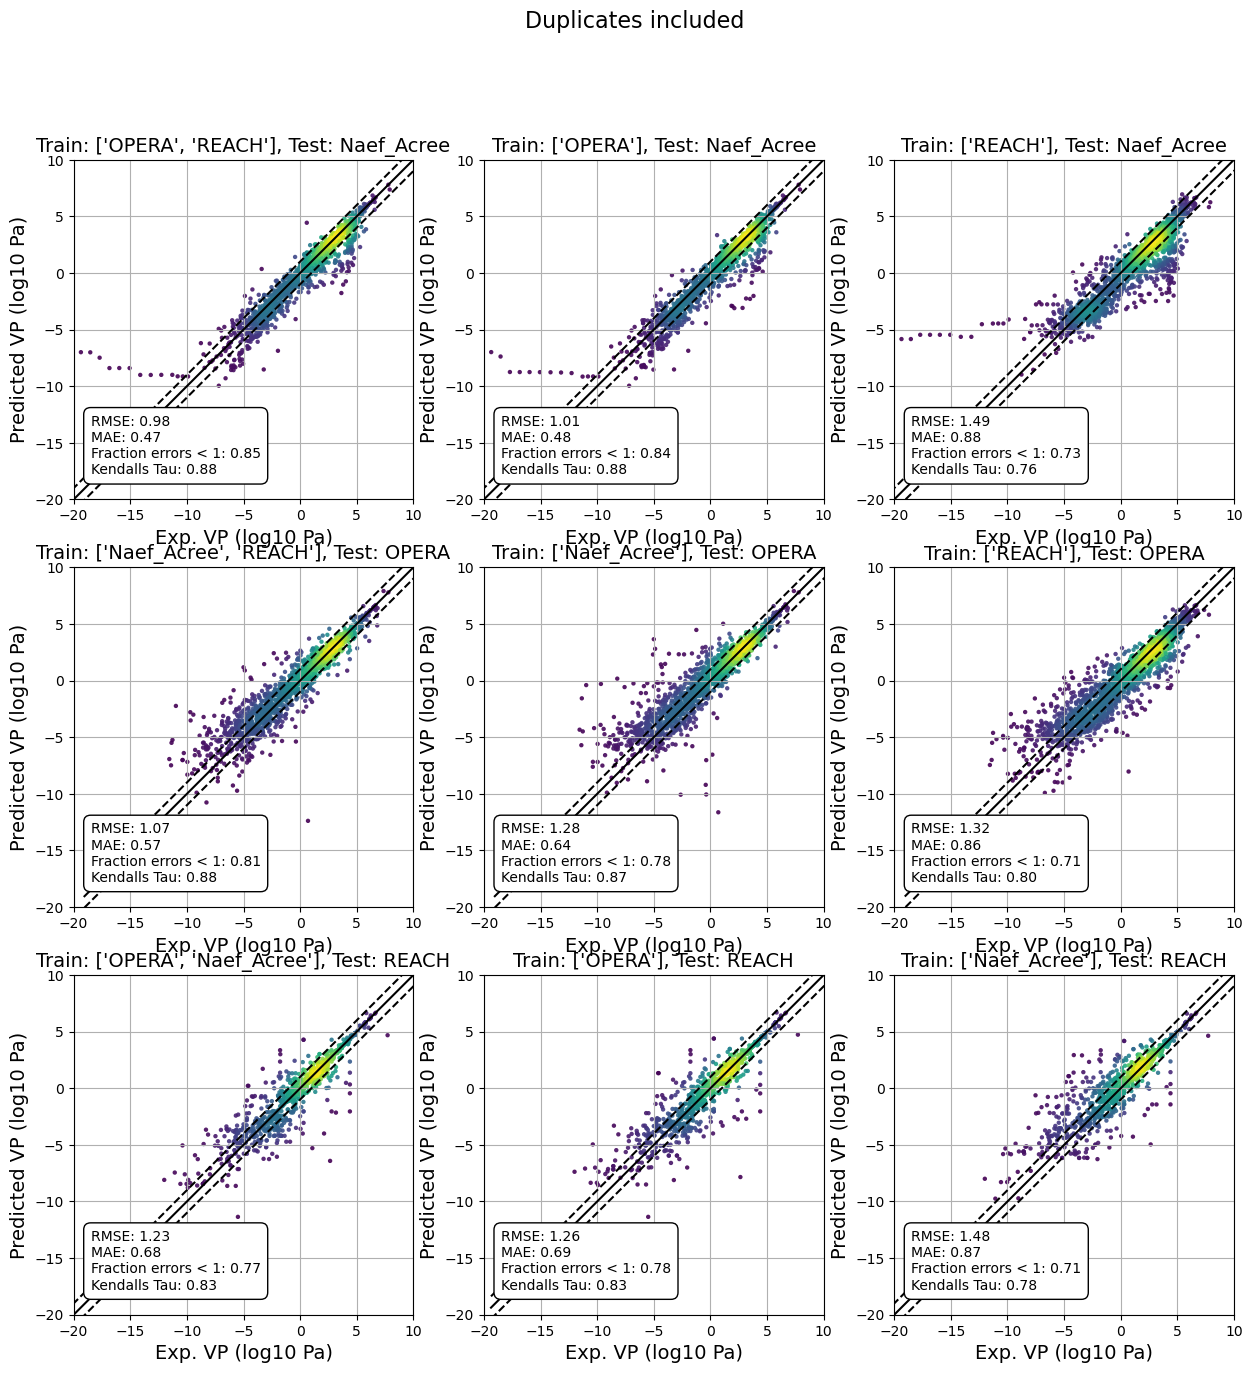

In [ ]:
density_plot_multiple_custom_cross(trues_sorted, preds_sorted, bounds=[-20,10], titles=titles_sorted,global_title='Duplicates included',name='test')

In [15]:
#custom sort source: first PHYSPROP, then Naef_Acree, then REACH
df_combined_desc.loc[df_combined_desc['source']=='OPERA','source'] = '1_OPERA'
df_combined_desc.loc[df_combined_desc['source']=='Naef_Acree','source'] = '2_Naef_Acree'
df_combined_desc.loc[df_combined_desc['source']=='REACH','source'] = '3_REACH'
df_combined_desc.sort_values(by=['source'],inplace=True,ascending=True)
#rename back
df_combined_desc.loc[df_combined_desc['source']=='1_OPERA','source'] = 'OPERA'
df_combined_desc.loc[df_combined_desc['source']=='2_Naef_Acree','source'] = 'Naef_Acree'
df_combined_desc.loc[df_combined_desc['source']=='3_REACH','source'] = 'REACH'
df_combined_desc
#drop duplicates
df_combined_desc_unqiue = df_combined_desc.drop_duplicates(subset=['inchikey'],keep='first')
preds_sorted, trues_sorted, training_set_titles_sorted,validation_set_titles_sorted,titles_sorted = Dataset_Extraplotion_Train_Preds(df_combined_desc_unqiue)
density_plot_multiple_custom_cross(trues_sorted, preds_sorted, bounds=[-20,10], titles=titles_sorted,global_title='No overlap',name='test')


['OPERA', 'Naef_Acree']
REACH


KeyboardInterrupt: 

In [16]:
def train_grouped_kfold_local(df,params,descriptors,name='test',split_on = 'inchi',y='vp_log10pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=False):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    X = df[split_on].to_numpy()
    output = ([],[],[],[],[],[],[],[],[],[],[])
    for i, (train_index, test_index) in enumerate(rkf.split(X)):
        train_all = df[df[split_on].isin(X[train_index])]
        test_all = df[df[split_on].isin(X[test_index])]

        #ensure there is no overlap in inchi between train and test
        assert len(set(train_all[split_on]).intersection(set(test_all[split_on]))) == 0

        train_X = train_all[descriptors]
        train_y = train_all[y]
        test_X = test_all[descriptors]
        test_y = test_all[y]
        inchi_test = test_all[split_on]

        if normalize_x:
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X)
            test_X = scaler.transform(test_X)

        dtrain = xgb.DMatrix(train_X, label=train_y)
        dtest = xgb.DMatrix(test_X, label=test_y)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            verbose_eval=False
        )

        preds = model.predict(dtest)
        output[0].append(test_y.to_list())
        output[1].append(list(preds))
        output[2].append(inchi_test.to_list())


        #print the RMSEs
        rmse = mean_squared_error(test_y, preds, squared=False)
        print(f"Fold {i + 1}: RMSE = {rmse}")

    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(output, f)

    return output

In [17]:
def density_plot_multiple_custom_local(reals, predictions,molregnos, print_stats=True, bounds=None, titles=None,global_title=None,print_spearman=False,name=None):
    num_plots = len(reals)
    print(f'making {num_plots} plots')
    num_cols = min(num_plots, 3)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed for the grid
    #if you cant devide by 3, but can divide by 2, do two rows
    if num_plots % 3 != 0 and num_plots % 2 == 0:
        num_rows = 2
        num_cols = 2   
    if num_plots == 4:
        num_rows = 2
        num_cols = 2
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D
    
    for i in range(num_plots):
        print(f'plot {i+1} of {num_plots}')
        real = reals[i]
        prediction = predictions[i]
        rmses,maes,ebos,kts = [],[],[],[]
        for r,p in zip(real,prediction):
            RMSE, MAE, EBO, KT = getStatValues_v2(r, p)
            rmses.append(RMSE)
            maes.append(MAE)
            ebos.append(EBO)
            kts.append(KT)

        rmse_90_low,rmse_90_high = stats.norm.interval(confidence=0.90, 
                 loc=np.mean(rmses), 
                 scale=stats.sem(rmses)) 
        rmse_mean = np.mean(rmses)
        mae_90_low,mae_90_high = stats.norm.interval(confidence=0.90,
                    loc=np.mean(maes), 
                    scale=stats.sem(maes))
        mae_mean = np.mean(maes)
        ebo_90_low,ebo_90_high = stats.norm.interval(confidence=0.90,
                    loc=np.mean(ebos), 
                    scale=stats.sem(ebos))
        ebo_mean = np.mean(ebos)
        kt_90_low,kt_90_high = stats.norm.interval(confidence=0.90,
                    loc=np.mean(kts), 
                    scale=stats.sem(kts))
        kt_mean = np.mean(kts)
        
                                             
        molregno = molregnos[i]

        mrn = [item for sublist in molregno for item in sublist]
        real = [item for sublist in real for item in sublist]
        prediction = [item for sublist in prediction for item in sublist]
        # #make df of these three, and average over molregno
        df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
        df = df.groupby('molregno').mean()
        real = df['real'].tolist()
        prediction = df['prediction'].tolist()


        print(f'{len(real)} points')
        
        ax = axes[i]
        
        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]
        
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')
        dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")
        ax.axis([lower, upper, lower, upper])
        # ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMAE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', transform=ax.transAxes, fontsize=10, verticalalignment='top')
        text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMAE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', 
                    transform=ax.transAxes, fontsize=8, verticalalignment='top',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        
        if titles is not None and len(titles) > i:
            ax.set_title(titles[i], fontsize=14)
        ax.set_aspect('equal', 'box')
    
    # Remove any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    if global_title is not None:
        fig.suptitle(global_title, fontsize=16)
    
    # plt.tight_layout()
    if name:
        plt.savefig(name+'.png', dpi=600)
    plt.show()

def density_plot_single_custom_local(reals, predictions, molregnos, print_stats=True, bounds=None, title=None, print_spearman=False, name=None):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    rmses, maes, ebos, kts = [], [], [], []
    
    for r, p in zip(reals, predictions):
        RMSE, MAE, EBO, KT = getStatValues_v2(r, p)
        rmses.append(RMSE)
        maes.append(MAE)
        ebos.append(EBO)
        kts.append(KT)
    
    rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
    rmse_mean = np.mean(rmses)
    mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
    mae_mean = np.mean(maes)
    ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
    ebo_mean = np.mean(ebos)
    kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
    kt_mean = np.mean(kts)
    
    # molregno = molregnos[0]
    
    mrn = [item for sublist in molregnos for item in sublist]
    real = [item for sublist in reals for item in sublist]
    prediction = [item for sublist in predictions for item in sublist]
    
    df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
    df = df.groupby('molregno').mean()
    real = df['real'].tolist()
    prediction = df['prediction'].tolist()
    
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')
    
    dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
    z = dens_u.pdf([real, prediction])
    
    sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)
    
    ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
    ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
    ax.grid(True, which="both")
    
    if bounds is None:
        lower = min(prediction + real) - 2
        upper = max(prediction + real) + 2
    else:
        lower = bounds[0]
        upper = bounds[1]
    
    ax.axis([lower, upper, lower, upper])
    
    text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMAE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', 
                       transform=ax.transAxes, fontsize=12, verticalalignment='top',
                       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    if title is not None:
        ax.set_title(title, fontsize=14)
    
    ax.set_aspect('equal', 'box')
    
    if name:
        plt.savefig(name+'.png', dpi=600)
    
    plt.show()

In [18]:
outputs_combined_no_duplicates = train_grouped_kfold_local(df_combined_desc_unqiue,params,RDKit_feature_names,name='outputs_combined_no_duplicates',split_on = 'inchikey',y='log10_VP_Pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=False)

Fold 1: RMSE = 0.8278687220184451
Fold 2: RMSE = 1.0233920197702908
Fold 3: RMSE = 0.8082321461468324
Fold 4: RMSE = 0.9406021110952061
Fold 5: RMSE = 0.9153920372770442
Fold 6: RMSE = 0.9283971519145802
Fold 7: RMSE = 0.8764174949690908
Fold 8: RMSE = 0.9831351719582557
Fold 9: RMSE = 0.8761805890317979
Fold 10: RMSE = 0.9441830449058989
Fold 11: RMSE = 0.8641569478039967
Fold 12: RMSE = 0.9861551536053481
Fold 13: RMSE = 0.9552703022744745
Fold 14: RMSE = 0.82312198883735
Fold 15: RMSE = 0.8916453667780924


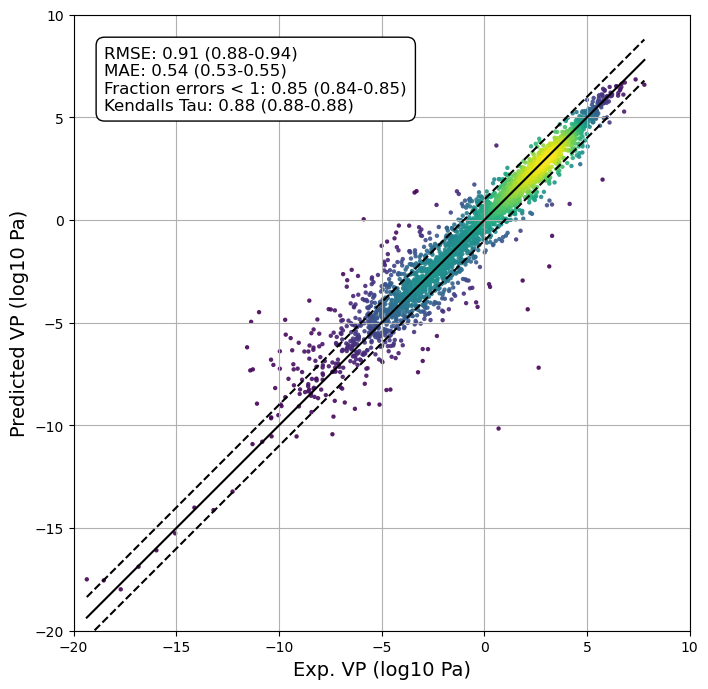

In [19]:
density_plot_single_custom_local(reals = outputs_combined_no_duplicates[0], predictions = outputs_combined_no_duplicates[1], bounds=[-20,10], molregnos=outputs_combined_no_duplicates[2])

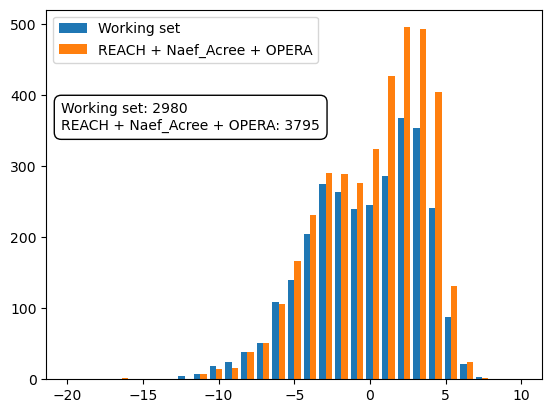

In [20]:
df_features =  pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/tmp_data/Current_set_2980_all_features_vp_in_log10_Pa.csv')
working_set_vals = df_features['vp_log10pa'].to_list()
working_set_vals = [float(i) for i in working_set_vals]
new_combined_set_vals = df_combined_desc_unqiue['log10_VP_Pa'].to_list()
new_combined_set_vals = [float(i) for i in new_combined_set_vals]
import numpy as np
import matplotlib.pyplot as plt

bins = np.linspace(-20, 10, 30)

plt.hist([working_set_vals, new_combined_set_vals], bins, label=['Working set', 'REACH + Naef_Acree + OPERA'])
#add textbox with sizes of both sets
text_box = plt.text(0.03, 0.75, f'Working set: {len(working_set_vals)}\nREACH + Naef_Acree + OPERA: {len(new_combined_set_vals)}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.legend(loc='upper left')
plt.show()



In [21]:
#make df of reals, preds, inchikeys, molregnos
reals = outputs_combined_no_duplicates[0]
preds = outputs_combined_no_duplicates[1]
inchikeys = outputs_combined_no_duplicates[2]
reals_flat = [item for sublist in reals for item in sublist]
preds_flat = [item for sublist in preds for item in sublist]
inchikeys_flat = [item for sublist in inchikeys for item in sublist]

df_CV_new_set = pd.DataFrame({'reals': reals_flat, 'preds': preds_flat, 'inchikey': inchikeys_flat})
#average over inchikey
df_CV_new_set = df_CV_new_set.groupby('inchikey').mean()
df_CV_new_set['abs_error'] = np.abs(df_CV_new_set['reals']-df_CV_new_set['preds'])
df_CV_new_set.sort_values(by=['abs_error'],ascending=False,inplace=True)
df_CV_new_set

reals      preds  abs_error
inchikey                                                    
ZVTSEGXUAUCYQH-UHFFFAOYSA-N   0.695302 -10.152462  10.847764
VUDOFEJVAFMLEC-UHFFFAOYSA-N   2.646404  -7.190548   9.836952
WQZGKKKJIJFFOK-UHFFFAOYSA-N -10.970898  -4.486351   6.484547
HLBLWEWZXPIGSM-UHFFFAOYSA-N   2.113943  -4.346654   6.460598
UZGLIIJVICEWHF-UHFFFAOYSA-N -11.356599  -4.956946   6.399652
...                                ...        ...        ...
WVRPFQGZHKZCEB-UHFFFAOYSA-N   3.329402   3.329611   0.000209
VLJXXKKOSFGPHI-UHFFFAOYSA-N   3.913802   3.913994   0.000192
POAOYUHQDCAZBD-UHFFFAOYSA-N   2.069402   2.069246   0.000156
WYACBZDAHNBPPB-UHFFFAOYSA-N   1.741902   1.741822   0.000081
MXLMTQWGSQIYOW-YFKPBYRVSA-N   3.086000   3.086043   0.000043

[3795 rows x 3 columns]

/tmp/ipykernel_1887678/1124942644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CV_new_set_error_over_2.sort_values(by=['abs_error'],ascending=False,inplace=True)
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


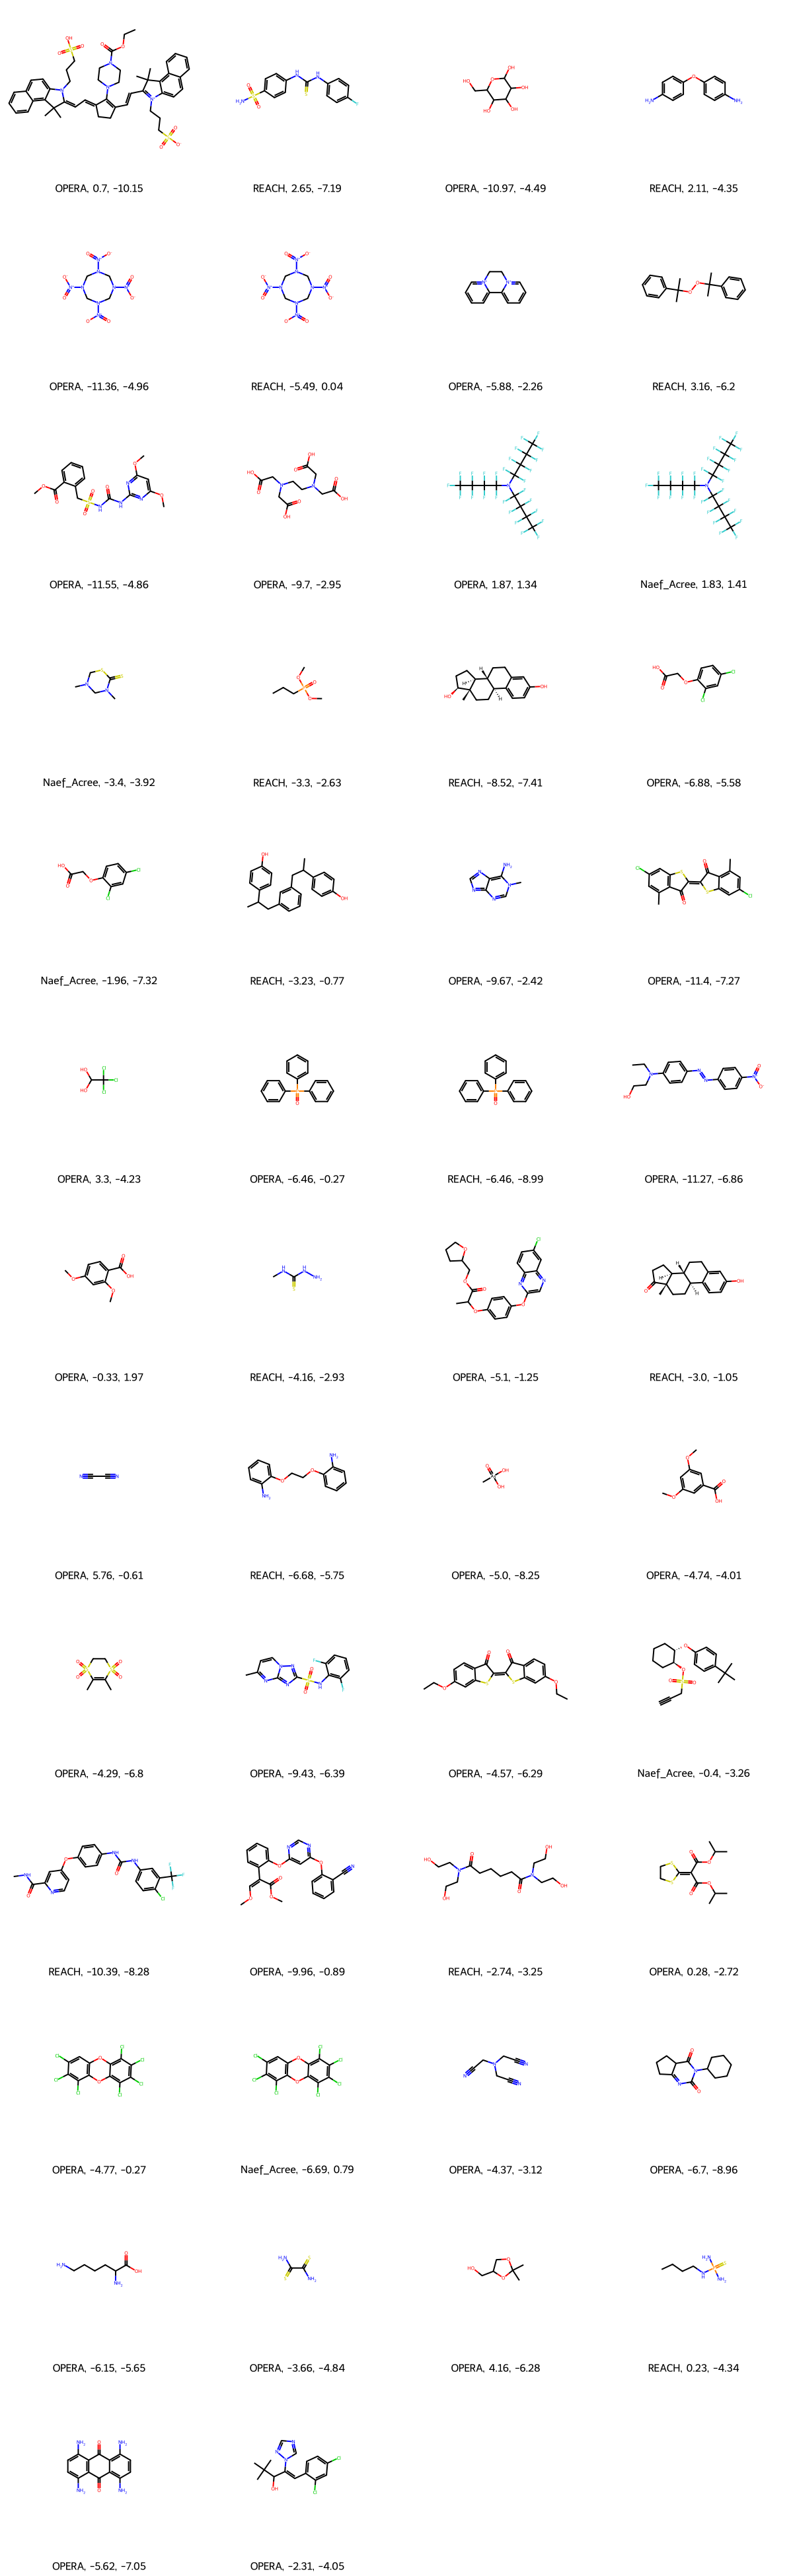

In [22]:
from rdkit.Chem import Draw
df_CV_new_set_error_over_2 = df_CV_new_set[df_CV_new_set['abs_error'] > 2]
df_CV_new_set_error_over_2.sort_values(by=['abs_error'],ascending=False,inplace=True)
df_CV_new_set_error_over_2
inchis_error_sorted = df_CV_new_set_error_over_2.index.to_list()
preds = df_CV_new_set_error_over_2['preds'].to_list()
sources, ground_truths, smiles = [], [], []
#iterate over inchis_error_sorted, get from df_combined standardized_smiles, log10_VP_Pa and source for all rows with this inchi and append values
for inchikey in inchis_error_sorted:
    df_subset = df_combined[df_combined['inchikey']==inchikey]
    sources.extend(df_subset['source'].to_list())
    ground_truths.extend(df_subset['log10_VP_Pa'].to_list())
    smiles.extend(df_subset['standardized_smiles'].to_list())
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300, 300), legends=[f'{s}, {round(g,2)}, {round(p,2)}' for s,g,p in zip(sources,ground_truths,preds)])
img

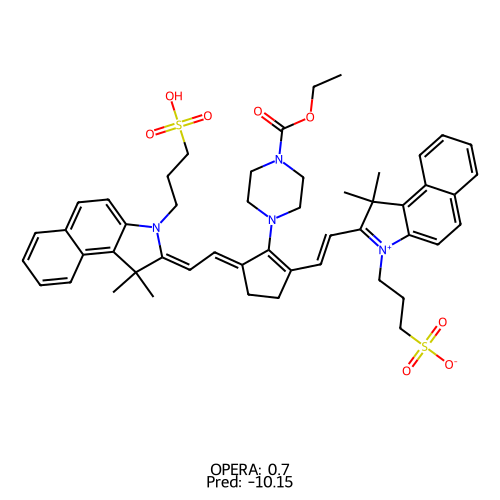

In [23]:
img = Draw.MolsToGridImage(mols[0:1], molsPerRow=1, subImgSize=(500, 500), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources,ground_truths,preds)])
img

In [24]:
df_opera_298K = pd.read_csv('../tmp_data/df_25_opera_standardized.csv')

x = df_opera_298K[df_opera_298K['inchikey']==inchis_error_sorted[0]]['SMILES'].to_list()[0]
#get molar weight of mols[0]
from rdkit.Chem import Descriptors
from rdkit import Chem
print(Descriptors.ExactMolWt(mols[0]))
x

906.369606816


'CCOC(=O)N1CCN(C2=C(/C=C/C3=[N+](CCCS(=O)(=O)[O-])c4ccc5ccccc5c4C3(C)C)CC/C2=C\\C=C2/N(CCCS(=O)(=O)O)c3ccc4ccccc4c3C2(C)C)CC1'

C50H58N4O8S2


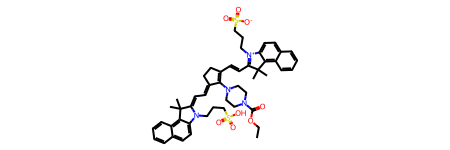

In [25]:
#get the mols again from the sdf: /localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/VP_QR.sdf
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_maxProperties = -1
mols_opera = Chem.SDMolSupplier('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/VP_QR.sdf')
#iterate, and keep if molwt bigger then 900
mols_opera_filtered = []
for mol in mols_opera:
    if Descriptors.ExactMolWt(mol) > 900:
        mols_opera_filtered.append(mol)
len(mols_opera_filtered)
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
print(CalcMolFormula(mols_opera_filtered[1]))
mols_opera_filtered[1]
#get formula

In [26]:
#very strange, tried to find in in the source, but without luck. Might have found the issue though:
#view all columns
pd.set_option('display.max_columns', None)
df_vp_update = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/VP_2.9_update.csv')
df_vp_update
#show here the source casrn of our weird compound: 541-88-8
df_vp_update[df_vp_update['CASRN']=='541-88-8']

CASRN DSSTOX_COMPOUND_ID DSSTOX_SUBSTANCE_ID  \
3115  541-88-8     DTXCID80818307     DTXSID701014649   

                PREFERRED_NAME     QC_LEVEL    Original_SMILES  \
3115  2-Chloroacetic anhydride  DSSTox_High  O=C(CCl)OC(=O)CCl   

      Number of connected components    Canonical_QSARr  \
3115                               1  O=C(CCl)OC(=O)CCl   

                                  InChI_Code_QSARr  \
3115  InChI=1S/C4H4Cl2O3/c5-1-3(7)9-4(8)2-6/h1-2H2   

                  InChI Key_QSARr Salt_Solvent  Salt_Solvent_ID  \
3115  PNVPNXKRAUBJGW-UHFFFAOYSA-N          NaN                0   

      value_point_estimate  unit       pub_source_name CASRN_Arr[0]  \
3115             -1.429457  mmHg  PubChem(1), OChem(2)     541-88-8   

     CASRN_Arr[1] CASRN_Arr[2] DSSTOX_SUBSTANCE_ID_Arr[0]  \
3115          NaN          NaN            DTXSID701014649   

     DSSTOX_SUBSTANCE_ID_Arr[1] DSSTOX_SUBSTANCE_ID_Arr[2]  
3115                        NaN                        NaN

169.953749348


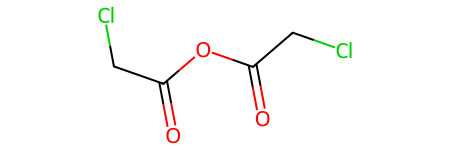

In [27]:
#here we see a completely different molecule!
print(Descriptors.ExactMolWt(Chem.MolFromSmiles('O=C(CCl)OC(=O)CCl')))
Chem.MolFromSmiles('O=C(CCl)OC(=O)CCl')

763-29-1 not the same
CCCC(C)=C
CCCCC(C)=C
----
2438-04-2 not the same
CC(C)C1C=CC=CC=1C(O)=O
CC(C)OC(=O)c1ccccc1
----
21981-48-6 not the same
CCCC(C)O[N+]([O-])=O
CC(C)CCO[N+]([O-])=O
----
541-88-8 not the same
O=C(CCl)OC(=O)CCl
CC1(C)/C(=C\C=C2/CCC(C=CC3=[N+](CCCS([O-])(=O)=O)c4ccc5ccccc5c4C3(C)C)=C/2N2CCN(CC2)C(=O)OCC)/N(CCCS(O)(=O)=O)c2ccc3ccccc3c12.CCN(CC)CC
----
1538-75-6 not the same
CC(C)(C)C(=O)OC(=O)C(C)(C)C
[Pr+3].CC(C)(C)C(=O)[CH-]C(=O)C(C)(C)C.CC(C)(C)C(=O)[CH-]C(=O)C(C)(C)C.CC(C)(C)C(=O)[CH-]C(=O)C(C)(C)C
----
4101-68-2 not the same
BrCCCCCCCCCCBr
CCCCCCCCC(Br)CBr
----
19398-53-9 not the same
CC(Br)CC(C)Br
CCCC(Br)CBr
----


[10:08:16] Initializing MetalDisconnector
[10:08:16] Running MetalDisconnector
[10:08:16] Initializing Normalizer
[10:08:16] Running Normalizer
[10:08:16] Running LargestFragmentChooser
[10:08:16] Fragment: C=C(C)CCC
[10:08:16] New largest fragment: C=C(C)CCC (18)
[10:08:16] Running Uncharger
[10:08:16] Initializing MetalDisconnector
[10:08:16] Running MetalDisconnector
[10:08:16] Initializing Normalizer
[10:08:16] Running Normalizer
[10:08:16] Initializing MetalDisconnector
[10:08:16] Running MetalDisconnector
[10:08:16] Initializing Normalizer
[10:08:16] Running Normalizer
[10:08:16] Running LargestFragmentChooser
[10:08:16] Fragment: C=C(C)CCCC
[10:08:16] New largest fragment: C=C(C)CCCC (21)
[10:08:16] Running Uncharger
[10:08:16] Initializing MetalDisconnector
[10:08:16] Running MetalDisconnector
[10:08:16] Initializing Normalizer
[10:08:16] Running Normalizer
[10:08:16] Initializing MetalDisconnector
[10:08:16] Running MetalDisconnector
[10:08:16] Initializing Normalizer
[10:08:1

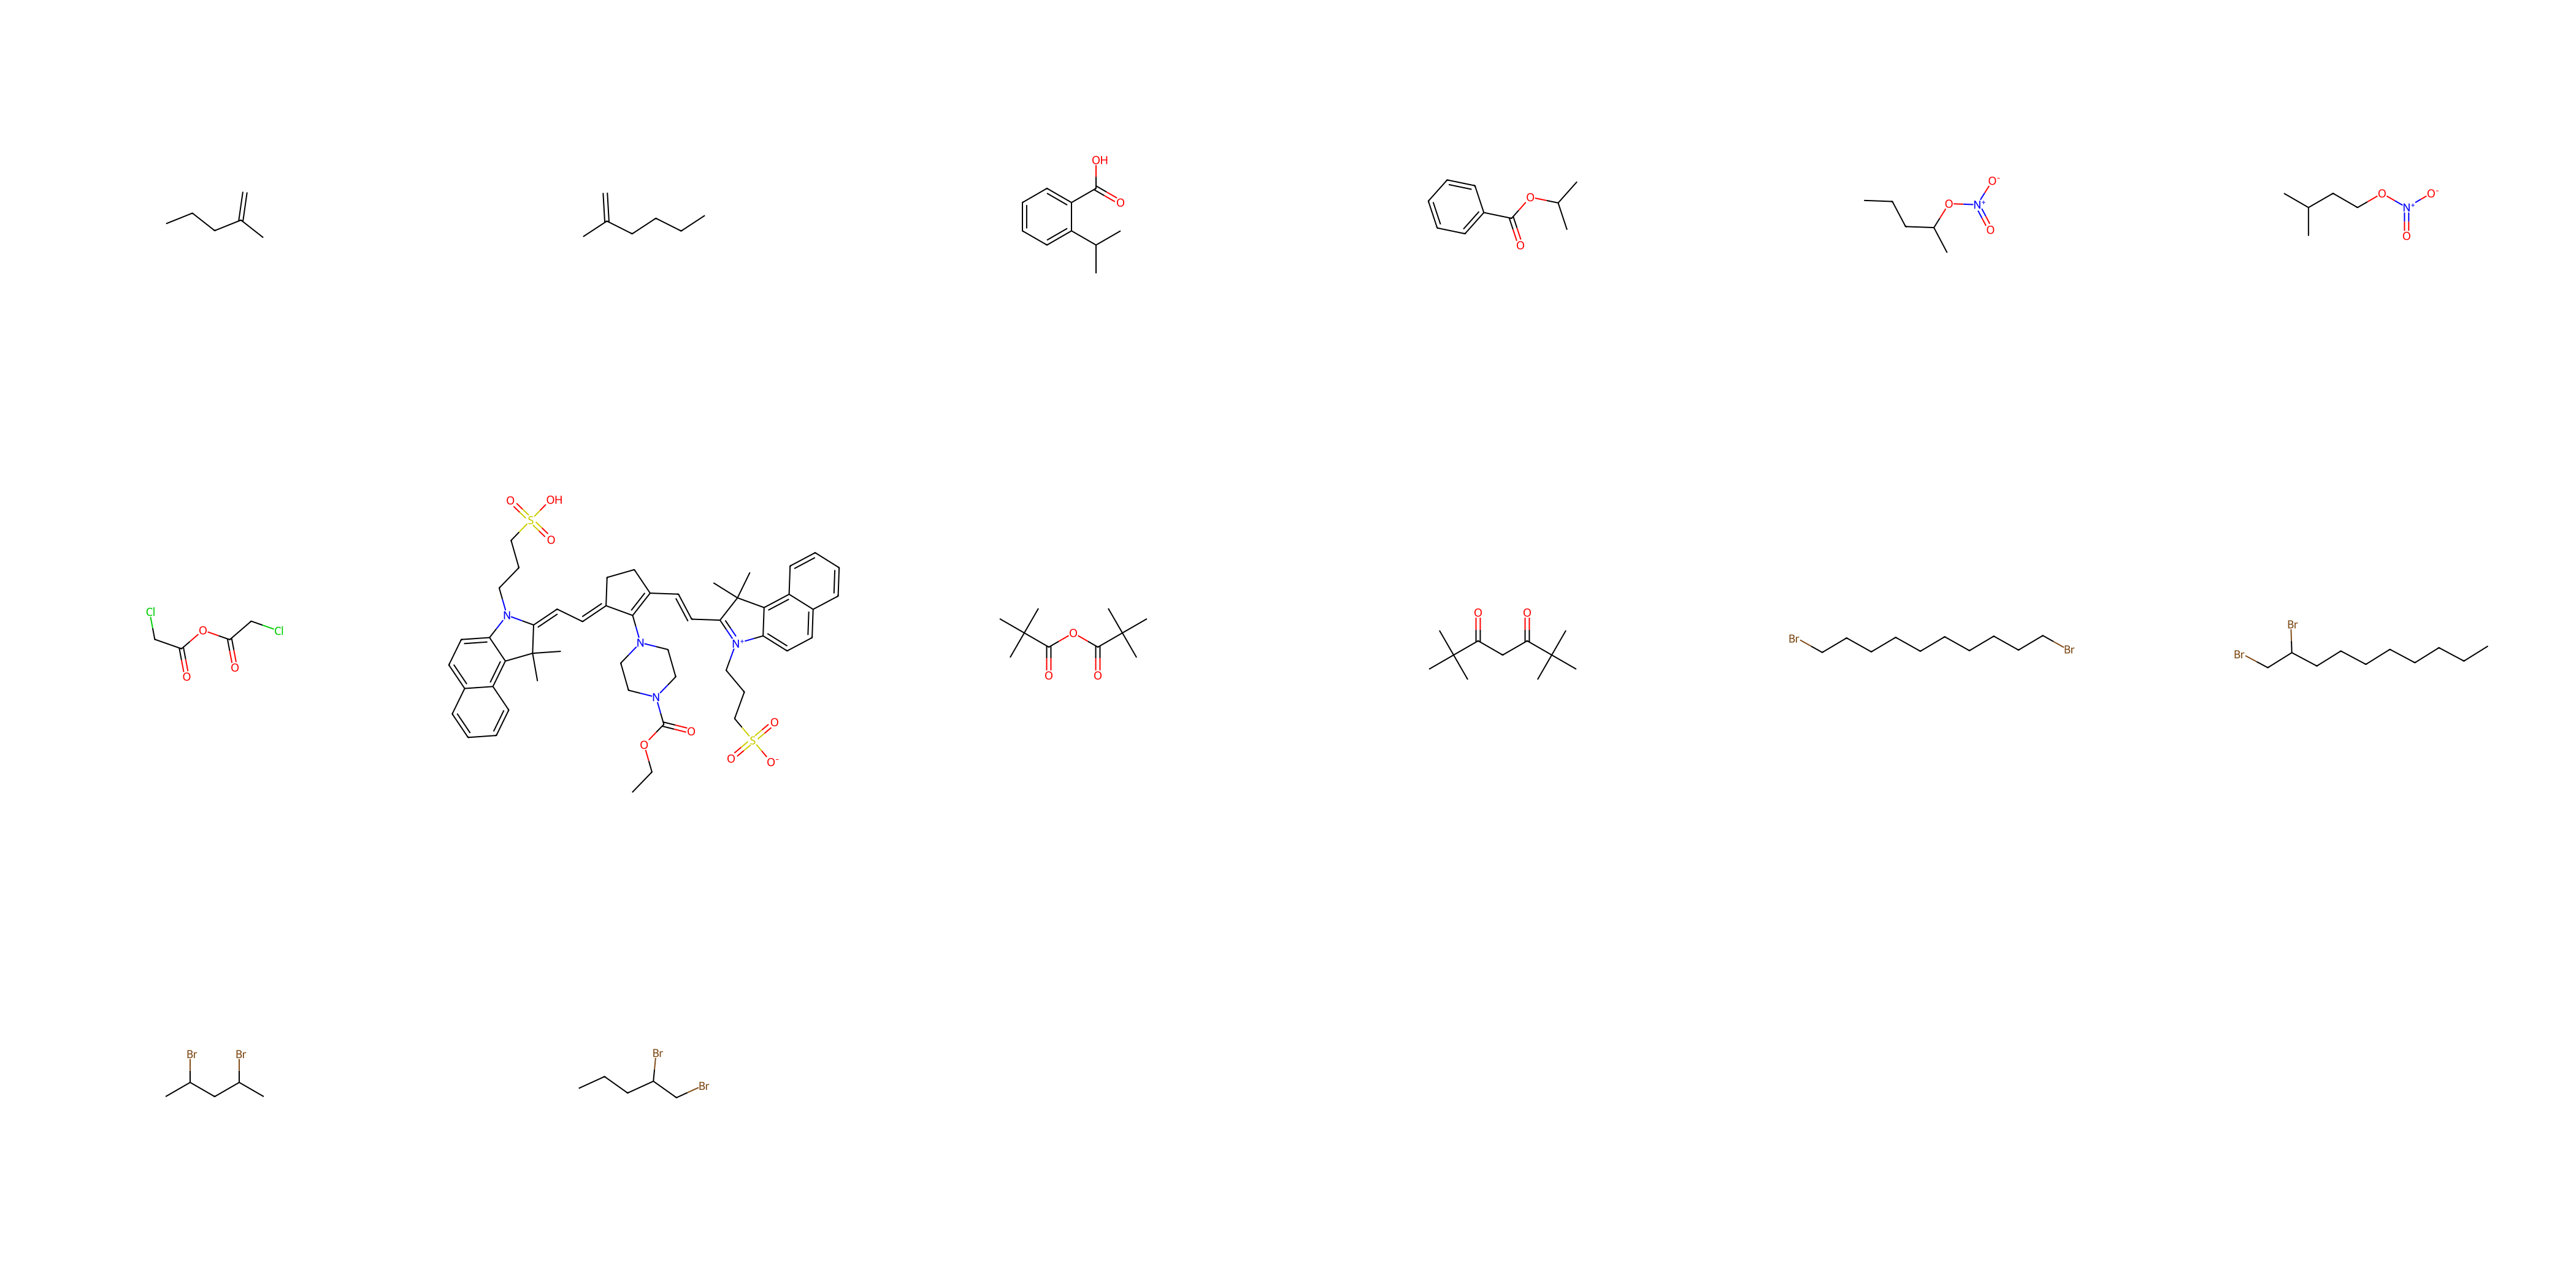

In [28]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
#is this an issue for others? lets pull all "CAS" and "source_casrn" from the molecules
OPERA_cas = [mol.GetProp('CAS') for mol in mols_opera]
OPERA_source_casrn = [mol.GetProp('source_casrn') for mol in mols_opera]
Original_SMILES = [mol.GetProp('Original_SMILES') for mol in mols_opera]
#get the ones where they are not the same at same index
OPERA_cas_not_same = []
OPERA_source_casrn_not_same = []
Original_SMILES_not_same = []
for cas,source_casrn,smi in zip(OPERA_cas,OPERA_source_casrn,Original_SMILES):
    if cas != source_casrn:
        OPERA_cas_not_same.append(cas)
        OPERA_source_casrn_not_same.append(source_casrn)
        Original_SMILES_not_same.append(smi)
#make df
df_OPREA_cas_not_same = pd.DataFrame({'CAS':OPERA_cas_not_same,'source_casrn':OPERA_source_casrn_not_same,'Original_SMILES':Original_SMILES_not_same})
df_OPREA_cas_not_same.head(50)
#drop if source_casrn = CAS +'|?'
df_OPREA_cas_not_same = df_OPREA_cas_not_same[df_OPREA_cas_not_same['source_casrn']!=df_OPREA_cas_not_same['CAS']+'|?']
df_OPREA_cas_not_same.head(50)
#get all the cas and source_casrn
OPERA_cas = df_OPREA_cas_not_same['CAS'].to_list()
OPERA_source_casrn = df_OPREA_cas_not_same['source_casrn'].to_list()
#now iterate over both. split on | when possible for both, and check if there is any overlap. in this case, get the index. drop all these indeces
indeces_to_drop = []
for i,(cas,source_casrn) in enumerate(zip(OPERA_cas,OPERA_source_casrn)):
    if '|' in cas:
        cas_split = cas.split('|')
        source_casrn_split = source_casrn.split('|')
        if len(set(cas_split).intersection(set(source_casrn_split))) > 0:
            indeces_to_drop.append(i)
#drop indeces
# df_OPREA_cas_not_same.drop(indeces_to_drop,inplace=True)
# df_OPREA_cas_not_same.head(50)
df_OPREA_cas_not_same
#drop indeces
#get cas with these indices
cas_to_drop = [OPERA_cas[i] for i in indeces_to_drop]
#drop these from df
df_OPREA_cas_not_same = df_OPREA_cas_not_same[~df_OPREA_cas_not_same['CAS'].isin(cas_to_drop)]
df_OPREA_cas_not_same
#for these, we are going to have to check if the original smiles in sdf are the same as smiles in the csv
#so, get SMILES from CAS via sdf
non_matching_smiles_df_update = []
non_matching_smiles_sdf = []
sources_cas_nrs = df_OPREA_cas_not_same['source_casrn'].to_list()
original_smils = df_OPREA_cas_not_same['Original_SMILES'].to_list()
cas_from_sdf_to_edit = []
smiles_to_edit_from,smiles_to_edit_to = [],[]
for cas,smi in zip(sources_cas_nrs,original_smils):
    #split by |
    cas_split = cas.split('|')
    for c in cas_split:
        #get value for Original_SMILES in df_vp_update for CASRN = c
        try:
            smiles_in_df = df_vp_update[df_vp_update['CASRN']==c]['Original_SMILES'].to_list()[0]
        except IndexError:
            continue
        if smiles_in_df != smi:
            print(f'{c} not the same')
            cas_from_sdf_to_edit.append(c)
            print(smiles_in_df)
            print(smi)
            print('----')
            non_matching_smiles_df_update.append(smiles_in_df)
            non_matching_smiles_sdf.append(smi)
            smiles_to_edit_from.append(smi)
            smiles_to_edit_to.append(smiles_in_df)
#draw these, side by side
mols_df = [Chem.MolFromSmiles(smi) for smi in non_matching_smiles_df_update]
mols_sdf = [Chem.MolFromSmiles(smi) for smi in non_matching_smiles_sdf]
#make combined list, where indices of these two are side by side
mols_combined = []
for i in range(len(mols_df)):
    mols_combined.append(mols_df[i])
    mols_combined.append(mols_sdf[i])
#draw
#standardize all mols
mols_combined_standardized = [rdMolStandardize.ChargeParent(mol) for mol in mols_combined]
img = Draw.MolsToGridImage(mols_combined_standardized, molsPerRow=6, subImgSize=(700, 700))
img


In [29]:
#nicely found, chapeau! now question is what we do with these: remove or replace? I guess replace.
#additionally, it would be interesting to see what the errors are on these.
standardized_smiles_sdf = [Chem.MolToSmiles(rdMolStandardize.ChargeParent(mol)) for mol in mols_sdf]
inchikeys_sdf = [Chem.MolToInchiKey(mol) for mol in mols_sdf]
#lets see if we can pull these from the combined df
df_wrong_mols = df_combined[df_combined['inchikey'].isin(inchikeys_sdf)]
df_wrong_mols
df_wrong_mols_2 = df_combined[df_combined['standardized_smiles'].isin(standardized_smiles_sdf)]
df_wrong_mols_2
#missing some here, idk why. Lets back track

[10:08:17] Initializing MetalDisconnector
[10:08:17] Running MetalDisconnector
[10:08:17] Initializing Normalizer
[10:08:17] Running Normalizer
[10:08:17] Running LargestFragmentChooser
[10:08:17] Fragment: C=C(C)CCCC
[10:08:17] New largest fragment: C=C(C)CCCC (21)
[10:08:17] Running Uncharger
[10:08:17] Initializing MetalDisconnector
[10:08:17] Running MetalDisconnector
[10:08:17] Initializing Normalizer
[10:08:17] Running Normalizer
[10:08:17] Initializing MetalDisconnector
[10:08:17] Running MetalDisconnector
[10:08:17] Initializing Normalizer
[10:08:17] Running Normalizer
[10:08:17] Running LargestFragmentChooser
[10:08:17] Fragment: CC(C)OC(=O)c1ccccc1
[10:08:17] New largest fragment: CC(C)OC(=O)c1ccccc1 (24)
[10:08:17] Running Uncharger
[10:08:17] Initializing MetalDisconnector
[10:08:17] Running MetalDisconnector
[10:08:17] Initializing Normalizer
[10:08:17] Running Normalizer
[10:08:17] Initializing MetalDisconnector
[10:08:17] Running MetalDisconnector
[10:08:17] Initializing

standardized_smiles  log10_VP_Pa                     inchikey  \
1562                   C=C(C)CCCC     4.162301  IRUDSQHLKGNCGF-UHFFFAOYSA-N   
1806          CC(C)OC(=O)c1ccccc1    -1.334398  FEXQDZTYJVXMOS-UHFFFAOYSA-N   
2022         CC(C)CCO[N+](=O)[O-]     2.835002  NTHGIYFSMNNHSC-UHFFFAOYSA-N   
2332  CC(C)(C)C(=O)CC(=O)C(C)(C)C     1.768402  YRAJNWYBUCUFBD-UHFFFAOYSA-N   
2337             CCCCCCCCC(Br)CBr    -0.303999  XBRBOTTWTQOCJH-UHFFFAOYSA-N   
2350                  CCCC(Br)CBr     2.278403  CITMYAPULDSOHG-UHFFFAOYSA-N   
4052                   C=C(C)CCCC     3.909000  IRUDSQHLKGNCGF-UHFFFAOYSA-N   

          source  
1562       OPERA  
1806       OPERA  
2022       OPERA  
2332       OPERA  
2337       OPERA  
2350       OPERA  
4052  Naef_Acree

In [30]:
#missing one, our biggest outlier! found out that there is something going wrong also here, with mols from sdf being different from the original smiles.
#demonstration:
from rdkit.Chem.MolStandardize.standardize import enumerate_tautomers_smiles, canonicalize_tautomer_smiles
mols = Chem.SDMolSupplier('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/VP_QR.sdf')
none_counter = 0
diff_counter = 0
different_mol_sdf, different_mol_original_smiles = [], []
for mol in mols:
    smiles_sdf = mol.GetProp('Original_SMILES')
    mol_from_original_smiles = Chem.MolFromSmiles(smiles_sdf)
    if mol_from_original_smiles is None:
        none_counter += 1
        continue
    mol_from_original_smiles = rdMolStandardize.ChargeParent(mol_from_original_smiles)
    mol_from_sdf = rdMolStandardize.ChargeParent(mol)
    standardized_original_smiles = Chem.MolToSmiles(mol_from_original_smiles)
    standardized_sdf = Chem.MolToSmiles(mol_from_sdf)
    canonical_tautomer_sdf = canonicalize_tautomer_smiles(standardized_original_smiles) #found out if you don't do this, you just get a lot of different tautomers
    canonical_tautomer_original_smiles = canonicalize_tautomer_smiles(standardized_sdf)
    canonical_tautomer_sdf_mol = Chem.MolFromSmiles(canonical_tautomer_sdf)
    canonical_tautomer_original_smiles_mol = Chem.MolFromSmiles(canonical_tautomer_original_smiles)
    if canonical_tautomer_sdf_mol.HasSubstructMatch(canonical_tautomer_original_smiles_mol,useChirality=True):
        continue

    different_mol_sdf.append(mol_from_sdf)
    different_mol_original_smiles.append(mol_from_original_smiles)
    diff_counter += 1
print(f'{none_counter} were None')
print(f'{diff_counter} were different')
#show the different ones
combined = [different_mol_sdf[0],different_mol_original_smiles[0],different_mol_sdf[1],different_mol_original_smiles[1]]
img = Draw.MolsToGridImage(combined, molsPerRow=2, subImgSize=(300, 300))
img

[10:08:17] Initializing MetalDisconnector
[10:08:17] Running MetalDisconnector
[10:08:17] Initializing Normalizer
[10:08:17] Running Normalizer
[10:08:17] Running LargestFragmentChooser
[10:08:17] Fragment: CC(O)C(=O)O
[10:08:17] New largest fragment: CC(O)C(=O)O (12)
[10:08:17] Running Uncharger
[10:08:17] Initializing MetalDisconnector
[10:08:17] Running MetalDisconnector
[10:08:17] Initializing Normalizer
[10:08:17] Running Normalizer
[10:08:17] Initializing MetalDisconnector
[10:08:17] Running MetalDisconnector
[10:08:17] Initializing Normalizer
[10:08:17] Running Normalizer
[10:08:17] Running LargestFragmentChooser
[10:08:17] Fragment: CC(O)C(=O)O
[10:08:17] New largest fragment: CC(O)C(=O)O (12)
[10:08:17] Running Uncharger
[10:08:17] Initializing MetalDisconnector
[10:08:17] Running MetalDisconnector
[10:08:17] Initializing Normalizer
[10:08:17] Running Normalizer
[10:08:17] Initializing MetalDisconnector
[10:08:17] Running MetalDisconnector
[10:08:17] Initializing Normalizer
[1

KeyboardInterrupt: 

So we identified two sources of error in the OPERA database:
1. Some newly added molecules are wrong
2. Some of the mols are different from the provided SMILES due to stereo reasons

How do we fix this?
1. Change wrong molecules to (probably) right molecules
2. Use stereo from original SMILES

Keep track, three dfs:
1. original
2. curated
3. Changes

In [ ]:
print(len(cas_from_sdf_to_edit))
print(cas_from_sdf_to_edit)
mols_to_correct = []
for m in mols_opera:
    for c in m.GetProp('source_casrn').split('|'):
        if c in cas_from_sdf_to_edit:
            mols_to_correct.append(m)
smiles_to_correct = [Chem.MolToSmiles(m) for m in mols_to_correct]
standardized_smiles_to_correct = [Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles(smi))) for smi in smiles_to_correct]
df_opera_298K_to_correct = df_opera_298K[df_opera_298K['SMILES'].isin(standardized_smiles_to_correct)]
print(len(df_opera_298K_to_correct))
df_opera_298K_to_correct
#get the correct smiles from the df_vp_update for these cas
correct_smiles = []
for cas in cas_from_sdf_to_edit:
    correct_smiles.append(df_vp_update[df_vp_update['CASRN']==cas]['Original_SMILES'].to_list()[0])
#standardize these too
correct_smiles = [Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles(smi))) for smi in correct_smiles]

#make df: standardized_smiles_to_correct and correct_smiles
df_smiles_to_correct = pd.DataFrame({'standardized_smiles_to_correct':standardized_smiles_to_correct,'correct_smiles':correct_smiles})
df_smiles_to_correct['inchikey'] = [Chem.MolToInchiKey(Chem.MolFromSmiles(smi)) for smi in df_smiles_to_correct['standardized_smiles_to_correct']]
inchikeys_to_correct = df_smiles_to_correct['inchikey'].to_list()
df_smiles_to_correct

7
['763-29-1', '2438-04-2', '21981-48-6', '541-88-8', '1538-75-6', '4101-68-2', '19398-53-9']
7


[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:28:35] Initializing Normalizer
[09:28:35] Running Normalizer
[09:28:35] Running LargestFragmentChooser
[09:28:35] Fragment: C=C(C)CCCC
[09:28:35] New largest fragment: C=C(C)CCCC (21)
[09:28:35] Running Uncharger
[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:28:35] Initializing Normalizer
[09:28:35] Running Normalizer
[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:28:35] Initializing Normalizer
[09:28:35] Running Normalizer
[09:28:35] Running LargestFragmentChooser
[09:28:35] Fragment: CC(C)OC(=O)c1ccccc1
[09:28:35] New largest fragment: CC(C)OC(=O)c1ccccc1 (24)
[09:28:35] Running Uncharger
[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:28:35] Initializing Normalizer
[09:28:35] Running Normalizer
[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:28:35] Initializing

standardized_smiles_to_correct  \
0                                         C=C(C)CCCC   
1                                CC(C)OC(=O)c1ccccc1   
2                               CC(C)CCO[N+](=O)[O-]   
3  CCOC(=O)N1CCN(C2=C(/C=C/C3=[N+](CCCS(=O)(=O)[O...   
4                        CC(C)(C)C(=O)CC(=O)C(C)(C)C   
5                                   CCCCCCCCC(Br)CBr   
6                                        CCCC(Br)CBr   

                correct_smiles                     inchikey  
0                    C=C(C)CCC  IRUDSQHLKGNCGF-UHFFFAOYSA-N  
1          CC(C)c1ccccc1C(=O)O  FEXQDZTYJVXMOS-UHFFFAOYSA-N  
2         CCCC(C)O[N+](=O)[O-]  NTHGIYFSMNNHSC-UHFFFAOYSA-N  
3            O=C(CCl)OC(=O)CCl  ZVTSEGXUAUCYQH-UHFFFAOYSA-N  
4  CC(C)(C)C(=O)OC(=O)C(C)(C)C  YRAJNWYBUCUFBD-UHFFFAOYSA-N  
5               BrCCCCCCCCCCBr  XBRBOTTWTQOCJH-UHFFFAOYSA-N  
6                CC(Br)CC(C)Br  CITMYAPULDSOHG-UHFFFAOYSA-N

In [ ]:
df_opera_298K_changes = df_opera_298K[df_opera_298K['inchikey'].isin(inchikeys_to_correct)]
df_opera_298K_changes['Comment'] = 'Corrected from original smiles according to VP_2.9_update.csv via CAS'
df_opera_298K_changes

/tmp/ipykernel_7391/1224014013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_opera_298K_changes['Comment'] = 'Corrected from original smiles according to VP_2.9_update.csv via CAS'


SMILES  VP log mmHg  \
1562                                         C=C(C)CCCC     2.037399   
1806                                CC(C)OC(=O)c1ccccc1    -3.459300   
2022                               CC(C)CCO[N+](=O)[O-]     0.710100   
2318  CCOC(=O)N1CCN(C2=C(/C=C/C3=[N+](CCCS(=O)(=O)[O...    -1.429600   
2332                        CC(C)(C)C(=O)CC(=O)C(C)(C)C    -0.356500   
2337                                   CCCCCCCCC(Br)CBr    -2.428901   
2350                                        CCCC(Br)CBr     0.153501   

      VP logPa                                standardized_smiles  \
1562  4.162301                                         C=C(C)CCCC   
1806 -1.334398                                CC(C)OC(=O)c1ccccc1   
2022  2.835002                               CC(C)CCO[N+](=O)[O-]   
2318  0.695302  CCOC(=O)N1CCN(C2=C(/C=C/C3=[N+](CCCS(=O)(=O)[O...   
2332  1.768402                        CC(C)(C)C(=O)CC(=O)C(C)(C)C   
2337 -0.303999                                   CCCCCCCCC(Br)CBr   
2350  2.278403                                        CCCC(Br)CBr   

                         inchikey  \
1562  IRUDSQHLKGNCGF-UHFFFAOYSA-N   
1806  FEXQDZTYJVXMOS-UHFFFAOYSA-N   
2022  NTHGIYFSMNNHSC-UHFFFAOYSA-N   
2318  ZVTSEGXUAUCYQH-UHFFFAOYSA-N   
2332  YRAJNWYBUCUFBD-UHFFFAOYSA-N   
2337  XBRBOTTWTQOCJH-UHFFFAOYSA-N   
2350  CITMYAPULDSOHG-UHFFFAOYSA-N   

                                                Comment  
1562  Corrected from original smiles according to VP...  
1806  Corrected from original smiles according to VP...  
2022  Corrected from original smiles according to VP...  
2318  Corrected from original smiles according to VP...  
2332  Corrected from original smiles according to VP...  
2337  Corrected from original smiles according to VP...  
2350  Corrected from original smiles according to VP...

In [ ]:
df_opera_298K_curated = df_opera_298K.copy()
#change smiles
for i,row in df_smiles_to_correct.iterrows():
    df_opera_298K_curated.loc[df_opera_298K_curated['inchikey']==row['inchikey'],'standardized_smiles'] = row['correct_smiles']
df_opera_298K_curated[df_opera_298K_curated['inchikey'].isin(inchikeys_to_correct)]
#save: df_opera_298K as df_opera_298K_original.csv, df_opera_298K_changes as df_opera_298K_changes.csv, df_opera_298K_curated as df_opera_298K_curated.csv
df_opera_298K.to_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/df_opera_298K_original.csv',index=False)
df_opera_298K_changes.to_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/df_opera_298K_changes.csv',index=False)
df_opera_298K_curated.to_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/df_opera_298K_curated.csv',index=False)

In [ ]:
df_CV_new_set

reals      preds  abs_error
inchikey                                                    
ZVTSEGXUAUCYQH-UHFFFAOYSA-N   0.695302 -10.152462  10.847764
VUDOFEJVAFMLEC-UHFFFAOYSA-N   2.646404  -7.190548   9.836952
WQZGKKKJIJFFOK-UHFFFAOYSA-N -10.970898  -4.486351   6.484547
HLBLWEWZXPIGSM-UHFFFAOYSA-N   2.113943  -4.346654   6.460598
UZGLIIJVICEWHF-UHFFFAOYSA-N -11.356599  -4.956946   6.399652
...                                ...        ...        ...
WVRPFQGZHKZCEB-UHFFFAOYSA-N   3.329402   3.329611   0.000209
VLJXXKKOSFGPHI-UHFFFAOYSA-N   3.913802   3.913994   0.000192
POAOYUHQDCAZBD-UHFFFAOYSA-N   2.069402   2.069246   0.000156
WYACBZDAHNBPPB-UHFFFAOYSA-N   1.741902   1.741822   0.000081
MXLMTQWGSQIYOW-YFKPBYRVSA-N   3.086000   3.086043   0.000043

[3795 rows x 3 columns]

In [ ]:
df_CV_new_set
#index is inchi. Get only those that are in inchikeys_to_correct
df_CV_new_set_to_correct = df_CV_new_set[df_CV_new_set.index.isin(inchikeys_to_correct)]
df_CV_new_set_to_correct

reals      preds  abs_error
inchikey                                                   
ZVTSEGXUAUCYQH-UHFFFAOYSA-N  0.695302 -10.152462  10.847764
FEXQDZTYJVXMOS-UHFFFAOYSA-N -1.334398   1.400061   2.734459
YRAJNWYBUCUFBD-UHFFFAOYSA-N  1.768402   1.283536   0.484866
NTHGIYFSMNNHSC-UHFFFAOYSA-N  2.835002   2.564057   0.270946
IRUDSQHLKGNCGF-UHFFFAOYSA-N  4.162301   3.966562   0.195739
XBRBOTTWTQOCJH-UHFFFAOYSA-N -0.303999  -0.346013   0.042014
CITMYAPULDSOHG-UHFFFAOYSA-N  2.278403   2.295130   0.016728

In [ ]:
df_combined

standardized_smiles  log10_VP_Pa  \
0                              CC(O)C(=O)O     1.035002   
1                 O=C(O)c1c(Cl)ccc(Cl)c1Cl    -1.134698   
2         c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34    -6.135498   
3     COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C    -4.594099   
4                     O=C(O)c1cccc(Cl)c1Cl    -1.517198   
...                                    ...          ...   
5621                                   FCF     6.230704   
5622                                   C#C     5.843183   
5623                                  C=CF     6.232996   
5624                                FC(F)F     6.672597   
5625                               C=C(F)F     6.602060   

                         inchikey source  
0     JVTAAEKCZFNVCJ-UHFFFAOYSA-N  OPERA  
1     XZIDTOHMJBOSOX-UHFFFAOYSA-N  OPERA  
2     FMMWHPNWAFZXNH-UHFFFAOYSA-N  OPERA  
3     ZPUCINDJVBIVPJ-UHFFFAOYSA-N  OPERA  
4     QAOJBHRZQQDFHA-UHFFFAOYSA-N  OPERA  
...                           ...    ...  
5621  RWRIWBAIICGTTQ-UHFFFAOYSA-N  REACH  
5622  HSFWRNGVRCDJHI-UHFFFAOYSA-N  REACH  
5623  XUCNUKMRBVNAPB-UHFFFAOYSA-N  REACH  
5624  XPDWGBQVDMORPB-UHFFFAOYSA-N  REACH  
5625  BQCIDUSAKPWEOX-UHFFFAOYSA-N  REACH  

[5626 rows x 4 columns]

In [ ]:
from rdkit.Chem import Draw
df_CV_new_set_error_over_2 = df_CV_new_set[df_CV_new_set['abs_error'] > 2]
df_CV_new_set_error_over_2.sort_values(by=['abs_error'],ascending=False,inplace=True)
df_CV_new_set_error_over_2
inchis_error_sorted = df_CV_new_set_error_over_2.index.to_list()
preds = df_CV_new_set_error_over_2['preds'].to_list()
sources, ground_truths, smiles = [], [], []
pred_list,inchikey_list = [],[]
for inchikey,pred in zip(inchis_error_sorted,preds):
    df_subset = df_combined[df_combined['inchikey']==inchikey]
    print(len(df_subset))
    sources.extend(df_subset['source'].to_list())
    ground_truths.extend(df_subset['log10_VP_Pa'].to_list())
    smiles.extend(df_subset['standardized_smiles'].to_list())
    inchikey_list.extend(df_subset['inchikey'].to_list())
    pred_list.extend([pred]*len(df_subset))
df_to_check = pd.DataFrame({'source':sources,'ground_truth':ground_truths,'smiles':smiles,'preds':pred_list,'inchikey':inchikey_list})
df_to_check

1
1
1
1
2
1
1
1
1
2
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
3
3
1
1
1
1
1
1
1
4
1
2
2
1
1
1
1
3
1
2
1
3
1
1
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
1
1
1
1
2
1
2
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
2
1
1
2
2
2


/tmp/ipykernel_7391/2086030014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CV_new_set_error_over_2.sort_values(by=['abs_error'],ascending=False,inplace=True)


source  ground_truth  \
0         OPERA      0.695302   
1         REACH      2.646404   
2         OPERA    -10.970898   
3         REACH      2.113943   
4         OPERA    -11.356599   
..          ...           ...   
172       REACH     -9.284034   
173       OPERA     -8.327298   
174  Naef_Acree     -5.714000   
175       REACH    -10.185087   
176       REACH     -7.966576   

                                                smiles      preds  \
0    CCOC(=O)N1CCN(C2=C(/C=C/C3=[N+](CCCS(=O)(=O)[O... -10.152462   
1               NS(=O)(=O)c1ccc(NC(=S)Nc2ccc(F)cc2)cc1  -7.190548   
2                                 OCC1OC(O)C(O)C(O)C1O  -4.486351   
3                              Nc1ccc(Oc2ccc(N)cc2)cc1  -4.346654   
4    O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...  -4.956946   
..                                                 ...        ...   
172   CNc1ccc(C(O)(c2ccc(N(C)C)cc2)c2ccc(N(C)C)cc2)cc1  -7.273036   
173      Clc1cc2c(oc3c(Cl)c(Cl)c(Cl)c(Cl)c32)c(Cl)c1Cl  -6.319046   
174      Clc1cc2c(oc3c(Cl)c(Cl)c(Cl)c(Cl)c32)c(Cl)c1Cl  -6.319046   
175    O=C(c1ccc2c(c1)C(=O)OC2=O)c1ccc2c(c1)C(=O)OC2=O  -8.181390   
176    O=C(c1ccc2c(c1)C(=O)OC2=O)c1ccc2c(c1)C(=O)OC2=O  -8.181390   

                        inchikey  
0    ZVTSEGXUAUCYQH-UHFFFAOYSA-N  
1    VUDOFEJVAFMLEC-UHFFFAOYSA-N  
2    WQZGKKKJIJFFOK-UHFFFAOYSA-N  
3    HLBLWEWZXPIGSM-UHFFFAOYSA-N  
4    UZGLIIJVICEWHF-UHFFFAOYSA-N  
..                           ...  
172  MAGJOSJRYKEYAZ-UHFFFAOYSA-N  
173  WDMKCPIVJOGHBF-UHFFFAOYSA-N  
174  WDMKCPIVJOGHBF-UHFFFAOYSA-N  
175  VQVIHDPBMFABCQ-UHFFFAOYSA-N  
176  VQVIHDPBMFABCQ-UHFFFAOYSA-N  

[177 rows x 5 columns]

In [ ]:
df_combined[df_combined['inchikey'] == 'VUDOFEJVAFMLEC-UHFFFAOYSA-N']
#get inchikey from NS(=O)(=O)c1ccc(NC(=S)Nc2ccc(F)cc2)cc1	
print(Chem.MolToInchiKey(Chem.MolFromSmiles('NS(=O)(=O)c1ccc(NC(=S)Nc2ccc(F)cc2)cc1')))

VUDOFEJVAFMLEC-UHFFFAOYSA-N


In [ ]:
df_combined

standardized_smiles  log10_VP_Pa  \
0                              CC(O)C(=O)O     1.035002   
1                 O=C(O)c1c(Cl)ccc(Cl)c1Cl    -1.134698   
2         c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34    -6.135498   
3     COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C    -4.594099   
4                     O=C(O)c1cccc(Cl)c1Cl    -1.517198   
...                                    ...          ...   
5621                                   FCF     6.230704   
5622                                   C#C     5.843183   
5623                                  C=CF     6.232996   
5624                                FC(F)F     6.672597   
5625                               C=C(F)F     6.602060   

                         inchikey source  
0     JVTAAEKCZFNVCJ-UHFFFAOYSA-N  OPERA  
1     XZIDTOHMJBOSOX-UHFFFAOYSA-N  OPERA  
2     FMMWHPNWAFZXNH-UHFFFAOYSA-N  OPERA  
3     ZPUCINDJVBIVPJ-UHFFFAOYSA-N  OPERA  
4     QAOJBHRZQQDFHA-UHFFFAOYSA-N  OPERA  
...                           ...    ...  
5621  RWRIWBAIICGTTQ-UHFFFAOYSA-N  REACH  
5622  HSFWRNGVRCDJHI-UHFFFAOYSA-N  REACH  
5623  XUCNUKMRBVNAPB-UHFFFAOYSA-N  REACH  
5624  XPDWGBQVDMORPB-UHFFFAOYSA-N  REACH  
5625  BQCIDUSAKPWEOX-UHFFFAOYSA-N  REACH  

[5626 rows x 4 columns]

In [ ]:
df_CV_new_set #get where index is VUDOFEJVAFMLEC-UHFFFAOYSA-N
df_CV_new_set.loc['VUDOFEJVAFMLEC-UHFFFAOYSA-N']

reals        2.646404
preds       -7.190548
abs_error    9.836952
Name: VUDOFEJVAFMLEC-UHFFFAOYSA-N, dtype: float64

In [ ]:
#can we find it in the cosmo data?
df_cosmo_reach = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/REACH/REACH_paper_curation_cosmo_vals.csv')
df_cosmo_reach['standardized_smiles'] = df_cosmo_reach['SMILES according to CAS RN'].apply(lambda x: Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles(x))))
df_cosmo_reach['inchikey'] = df_cosmo_reach['standardized_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))

[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:28:35] Initializing Normalizer
[09:28:35] Running Normalizer
[09:28:35] Running LargestFragmentChooser
[09:28:35] Fragment: O=C1N2CN3C(=O)N4CN5C(=O)N6CN7C(=O)N8CN9C(=O)N%10CN%11C(=O)N%12CN%13C(=O)N%14CN%15C(=O)N%16CN1C1C2N2CN%17C(=O)N(CN%18C(=O)N(CN%19C(=O)N(CN%20C(=O)N(CN%21C(=O)N(CN%22C(=O)N(CN%23C(=O)N(CN1C2=O)C%16C%15%23)C%14C%13%22)C%12C%11%21)C%10C9%20)C8C7%19)C6C5%18)C4C3%17
[09:28:35] New largest fragment: O=C1N2CN3C(=O)N4CN5C(=O)N6CN7C(=O)N8CN9C(=O)N%10CN%11C(=O)N%12CN%13C(=O)N%14CN%15C(=O)N%16CN1C1C2N2CN%17C(=O)N(CN%18C(=O)N(CN%19C(=O)N(CN%20C(=O)N(CN%21C(=O)N(CN%22C(=O)N(CN%23C(=O)N(CN1C2=O)C%16C%15%23)C%14C%13%22)C%12C%11%21)C%10C9%20)C8C7%19)C6C5%18)C4C3%17 (144)
[09:28:35] Running Uncharger
[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:28:35] Initializing Normalizer
[09:28:35] Running Normalizer
[09:28:35] Initializing MetalDisconnector
[09:28:35] Runnin

[09:28:35] Running LargestFragmentChooser
[09:28:35] Fragment: c1ccc(-c2ccc(-c3nc(-c4ccc(-c5ccccc5)cc4)nc(-c4ccc(-c5ccccc5)cc4)n3)cc2)cc1
[09:28:35] New largest fragment: c1ccc(-c2ccc(-c3nc(-c4ccc(-c5ccccc5)cc4)nc(-c4ccc(-c5ccccc5)cc4)n3)cc2)cc1 (69)
[09:28:35] Running Uncharger
[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:28:35] Initializing Normalizer
[09:28:35] Running Normalizer
[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:28:35] Initializing Normalizer
[09:28:35] Running Normalizer
[09:28:35] Running LargestFragmentChooser
[09:28:35] Fragment: CCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)[O-]
[09:28:35] New largest fragment: CCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)[O-] (50)
[09:28:35] Running Uncharger
[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:28:35] Initializing Normalizer
[09:28:35] Running Normalizer
[09:28:35] Initializing MetalDisconnector
[09:28:35] Running MetalDisconnector
[09:2

In [ ]:
df_reach_standardized_uncurated = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/tmp_data/REACH_standardized_not_cleaned.csv')
df_reach_standardized_uncurated[df_reach_standardized_uncurated['standardized_smiles'] == 'NS(=O)(=O)c1ccc(NC(=S)Nc2ccc(F)cc2)cc1']

#name        cas                   iupacName  \
1133  2,2-bis(methylthio)propane  6156-18-9  2,2-bis(methylthio)propane   

      P (upperQualifier)  P (upperValue)  P (lowerQualifier)  P (lowerValue)  \
1133                 NaN             NaN                 NaN           443.0   

     P (unit)  T (upperQualifier)  T (upperValue)  T (lowerQualifier)  \
1133       Pa                 NaN             NaN                 NaN   

      T (lowerValue) T (unit)  VP_Pa  Temperature_K  \
1133            25.0        C  443.0         298.15   

                                        SMILES  \
1133  N[S](=O)(=O)c1ccc(NC(=S)Nc2ccc(F)cc2)cc1   

                         standardized_smiles  log10_VP_Pa  NumHeavyAtoms  
1133  NS(=O)(=O)c1ccc(NC(=S)Nc2ccc(F)cc2)cc1     2.646404             21

In [ ]:
# VUDOFEJVAFMLEC-UHFFFAOYSA-N
df_cosmo_reach[df_cosmo_reach['CAS_RN']=='6156-18-9']

Unnamed: 0  Factsheet_ID Substance_ID              Substance_Name  \
3907        3907         30186  100.105.201  2,2-bis(methylthio)propane   

          EC_No     CAS_RN Entry in ECHA DB correct? Substance Type  \
3907  478-900-1  6156-18-9                       yes        organic   

                     Composition Substance_Physical_State Registration_status  \
3907  mono-constituent substance                   liquid              Active   

     Registration_Type  Tonnage_Band_Displayed Molecular_Formula  \
3907              FULL  ≥ 100 to < 1000 tonnes           C5H12S2   

     SMILES according to CAS RN  pV [Pa] 25 °C  log10 KAW 25 °C  \
3907                CSC(C)(C)SC       370.8515        -1.397652   

     SW [mg/l] 25 °C  log10 KOW 25 °C   Tb [°C]  kOH [cm3/s] 25 °C  \
3907        447.2316         2.820648  161.6471       2.085690e-12   

      HO [bar] 25 °C  log10 KOC 25 °C  pV [Pa] 20 °C  log10 KAW 20 °C  \
3907        0.008405         2.013989       268.3178        -1.533763   

     SW [mg/l] 20 °C  log10 KOW 20 °C  HO [bar] 20 °C  log10 KOA 20 °C  \
3907        393.7799         2.813636        0.006205          4.39541   

      Different SMILES at pH 7.4 standardized_smiles  \
3907                       False         CSC(C)(C)SC   

                         inchikey  
3907  BBYNYNMPOUQKKS-UHFFFAOYSA-N

In [ ]:
import pickle
cas2smiles = pickle.load(open("/localhome/cschiebroek/ShuZe/vp/data cleaning/cas_id_2_smiles.pickle", "rb"))
cas2smiles_dict = {i:j for i,j in cas2smiles}
cas2smiles_dict['6156-18-9']

'N[S](=O)(=O)c1ccc(NC(=S)Nc2ccc(F)cc2)cc1'

new issue identified: incorrect cas2smiles_dict

In [ ]:
import cirpy
cirpy.resolve('6156-18-9', 'smiles')
#error in cirpy

'N[S](=O)(=O)c1ccc(NC(=S)Nc2ccc(F)cc2)cc1'

In [ ]:
#perhaps we can do a check, at least for the overlap, with the cosmo data
cas_reach = df_reach_standardized_uncurated['cas'].to_list()
cosmo = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/REACH/REACH_paper_curation_cosmo_vals.csv')
cosmo_with_overlapping_cas = cosmo[cosmo['CAS_RN'].isin(cas_reach)]
cosmo_with_overlapping_cas
cas_to_smiles_according_to_cosmo = {i:j for i,j in zip(cosmo_with_overlapping_cas['CAS_RN'],cosmo_with_overlapping_cas['SMILES according to CAS RN'])}
#now compare these with SMILES in df_reach_standardized_uncurated
smiles_used,smiles_according_to_cosmo_paper = [],[]
oopsie_counter = 0
for cas in cas_reach:
    try:
        smiles_according_to_cosmo_via_cas = cas_to_smiles_according_to_cosmo[cas]
        smiles_in_df = df_reach_standardized_uncurated[df_reach_standardized_uncurated['cas']==cas]['SMILES'].to_list()[0]
        #canonicalize both and check if the same
        smiles_according_to_cosmo_via_cas = Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles(smiles_according_to_cosmo_via_cas)))
        smiles_in_df = Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles(smiles_in_df)))
        inchi_via_cas = Chem.MolToInchiKey(Chem.MolFromSmiles(smiles_according_to_cosmo_via_cas))
        inchi_in_df = Chem.MolToInchiKey(Chem.MolFromSmiles(smiles_in_df))
        if inchi_via_cas != inchi_in_df:
            # print(f'{cas} not the same')
            # print(smiles_according_to_cosmo_via_cas)
            # print(smiles_in_df)
            # print('----')
            smiles_used.append(smiles_in_df)
            smiles_according_to_cosmo_paper.append(smiles_according_to_cosmo_via_cas)
            oopsie_counter += 1
    except KeyError:
        continue
# df_reach_standardized_uncurated['SMILES according to CAS RN'] = df_reach_standardized_uncurated['cas'].apply(lambda x: cas_to_smiles_according_to_cosmo[x] if x in cas_to_smiles_according_to_cosmo else None)
# df_reach_standardized_uncurated[df_reach_standardized_uncurated['SMILES according to CAS RN'].isna()]
# #check if these are in the cosmo data
oopsie_counter

[09:28:44] Initializing MetalDisconnector
[09:28:44] Running MetalDisconnector
[09:28:44] Initializing Normalizer
[09:28:44] Running Normalizer
[09:28:44] Running LargestFragmentChooser
[09:28:44] Fragment: O=C1CCCO1
[09:28:44] New largest fragment: O=C1CCCO1 (12)
[09:28:44] Running Uncharger
[09:28:44] Initializing MetalDisconnector
[09:28:44] Running MetalDisconnector
[09:28:44] Initializing Normalizer
[09:28:44] Running Normalizer
[09:28:44] Initializing MetalDisconnector
[09:28:44] Running MetalDisconnector
[09:28:44] Initializing Normalizer
[09:28:44] Running Normalizer
[09:28:44] Running LargestFragmentChooser
[09:28:44] Fragment: O=C1CCCO1
[09:28:44] New largest fragment: O=C1CCCO1 (12)
[09:28:44] Running Uncharger
[09:28:44] Initializing MetalDisconnector
[09:28:44] Running MetalDisconnector
[09:28:44] Initializing Normalizer
[09:28:44] Running Normalizer
[09:28:44] Initializing MetalDisconnector
[09:28:44] Running MetalDisconnector
[09:28:44] Initializing Normalizer
[09:28:44]

91

18.0


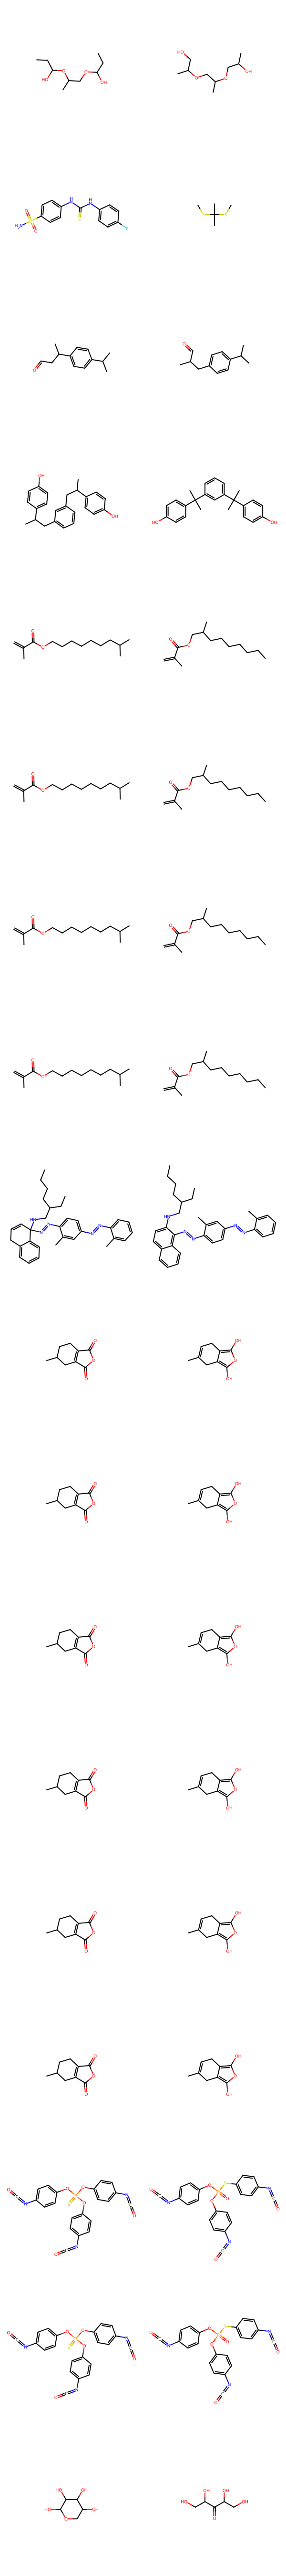

In [ ]:
#get the ones that are actually not the same
from rdkit.Chem.MolStandardize.rdMolStandardize import CanonicalTautomer 
no_match = []
for smi1,smi2 in zip(smiles_used,smiles_according_to_cosmo_paper):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #get same tautomer
    mol1 = CanonicalTautomer(mol1)
    mol2 = CanonicalTautomer(mol2)
    if mol1.HasSubstructMatch(mol2,useChirality=False):
        continue
    else:
        no_match.append(mol1)
        no_match.append(mol2)
#draw
print(len(no_match)/2)
img = Draw.MolsToGridImage(no_match, molsPerRow=2, subImgSize=(300, 300))
img

And again a new issue... great. I guess we found the one where it makes the most impact, but it just goes to show that this cirpy is not reliable. We have to find a better way.

In [ ]:
# Draw.MolsToGridImage(mols[1:2], molsPerRow=1, subImgSize=(500, 500), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[1:2],ground_truths[1:2],preds[1:2])])

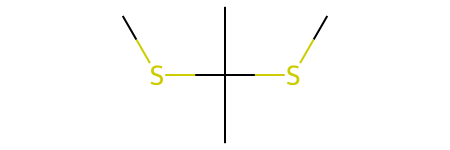

In [ ]:
Chem.MolFromSmiles('CSC(C)(C)SC')

#todo: find solution
Perhaps cas2smiles via the combined cosmo paper + others

Lets look at the next outlier

In [ ]:
df_to_check
#get smiles, preds, ground_truths, sources
smiles = df_to_check['smiles'].to_list()
preds = df_to_check['preds'].to_list()
ground_truths = df_to_check['ground_truth'].to_list()
sources = df_to_check['source'].to_list()
inchikeys = df_to_check['inchikey'].to_list()
#draw only number 3
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles[2:3]]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=1, subImgSize=(500, 500), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[2:3],ground_truths[2:3],preds[2:3])])
img

# mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles[2:12]]
# img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300, 300), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[2:12],ground_truths[2:12],preds[2:12])])
# img

NameError: name 'df_to_check' is not defined

In [ ]:
#interesting: we have seen the first one in REACH as being wrong. Could the same be the case for OPERA? As in, it is actually not cyclic glucose? Let check in df_combined
df_combined[df_combined['inchikey']== inchikeys[2]]
df_opera_298K = pd.read_csv('../tmp_data/df_25_opera_standardized.csv')
df_opera_298K[df_opera_298K['inchikey']== inchikeys[2]]
#I think this value is incorrect. The cited paper does not give an explicit value, only measured points in a different range with formula to extrapolate:

SMILES  VP log mmHg   VP logPa   standardized_smiles  \
1126  OCC1OC(O)C(O)C(O)C1O     -13.0958 -10.970898  OCC1OC(O)C(O)C(O)C1O   

                         inchikey  
1126  WQZGKKKJIJFFOK-UHFFFAOYSA-N

In [2]:
import numpy as np
def Get_VP_from_Clausius_Clapeyron(A,B,T_K,B_std = None):
    '''
    A and B are constants, T is temperature in Kelvin
    '''
    ln_P_pa = A - B/T_K
    P_pa = np.exp(ln_P_pa)
    if B_std:
        #calc upper and lower
        ln_P_pa_upper = A - (B+B_std)/T_K
        P_pa_upper = np.exp(ln_P_pa_upper)
        ln_P_pa_lower = A - (B-B_std)/T_K
        P_pa_lower = np.exp(ln_P_pa_lower)
        return P_pa,P_pa_upper,P_pa_lower
    
    return P_pa
A_d_glucose = 53.16
B_d_glucose_mean = 23383
B_d_glucose_std = 600
T_K = 298.15

print('VP according to Clausius_Clapeyron at 298.15 K: ', Get_VP_from_Clausius_Clapeyron(A_d_glucose,B_d_glucose_mean,T_K,B_std = B_d_glucose_std))
print('VP according to Clausius_Clapeyron at 395.55  K: ', Get_VP_from_Clausius_Clapeyron(A_d_glucose,B_d_glucose_mean,395.55))

VP according to Clausius_Clapeyron at 298.15 K:  (1.0633983078252218e-11, 1.4214037831673598e-12, 7.95562791148418e-11)
VP according to Clausius_Clapeyron at 395.55  K:  0.002592439092824961


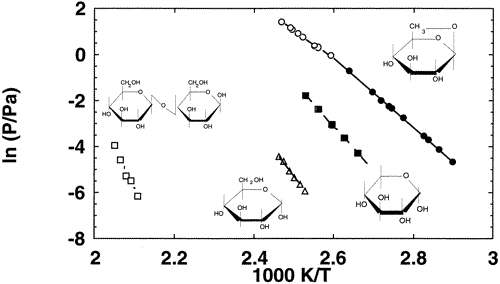

Value seems correct from this equation, but it's a huge extrapolation: the constants are calculated within a range of 10 degrees K (395-406)

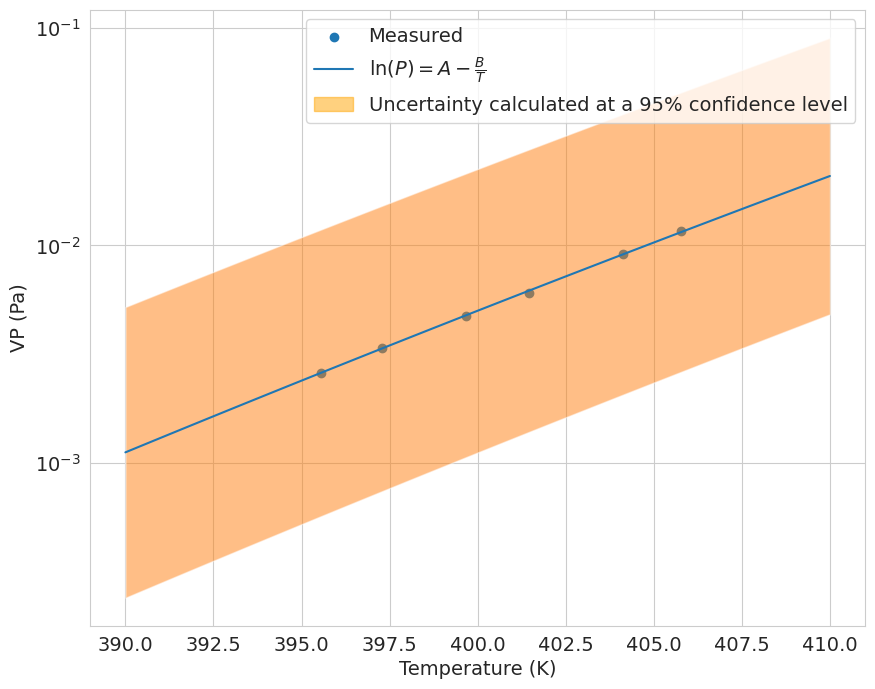

In [ ]:
#just for fun, lets plot these in context.
measured_vps = [0.00260,0.00337,0.00471 ,0.00606,0.00912 ,0.0116]
measured_temps = [395.55,397.29 ,399.67 ,401.47 ,404.12 ,405.78]
#do a plot of these, as well as the clausius clapeyron equation with the mean and std
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
#plot
fig,ax = plt.subplots(figsize=(10,8))
#plot measured
ax.scatter(measured_temps,measured_vps,label='Measured')
#plot clausius clapeyron
T_K = np.linspace(390,410,100)
vps = [Get_VP_from_Clausius_Clapeyron(A_d_glucose,B_d_glucose_mean,T,B_std = B_d_glucose_std) for T in T_K]
vp_means = [vp[0] for vp in vps] 
vp_upper = [vp[1] for vp in vps]
vp_lower = [vp[2] for vp in vps]
ax.plot(T_K,vp_means,label=r'$\ln(P) = A - \frac{B}{T}$')
ax.fill_between(T_K,vp_lower,vp_upper,alpha=0.5)
ax.set_xlabel('Temperature (K)',fontsize=14)
ax.set_ylabel('VP (Pa)',fontsize=14)
#add extrapolated point at 298.15 K
ax.fill_between([],[],[],color='orange',alpha=0.5,label='Uncertainty calculated at a 95% confidence level')

# ax.scatter(298.15,Get_VP_from_Clausius_Clapeyron(A_d_glucose,B_d_glucose_mean,298.15,B_std = B_d_glucose_std)[0],label='Extrapolated')
ax.legend(fontsize=14)
#add to legend: orange = std in B term
#y on log scale
#add text: ln(P) = A - B/T
ax.set_yscale('log')
#bigger ticks
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()


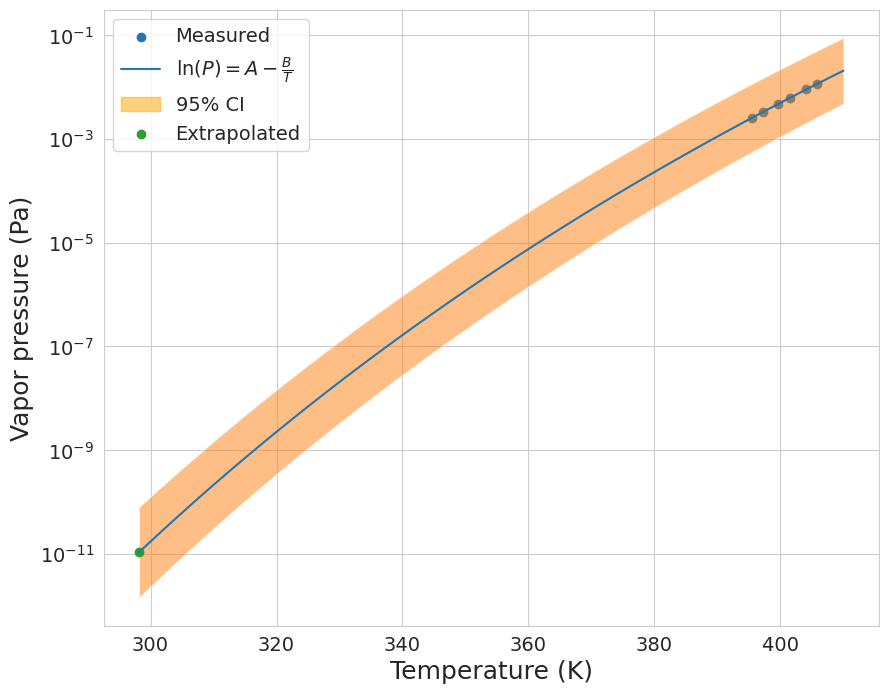

In [7]:
#just for fun, lets plot these in context.
measured_vps = [0.00260,0.00337,0.00471 ,0.00606,0.00912 ,0.0116]
measured_temps = [395.55,397.29 ,399.67 ,401.47 ,404.12 ,405.78]
#do a plot of these, as well as the clausius clapeyron equation with the mean and std
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
#plot
fig,ax = plt.subplots(figsize=(10,8))
#plot measured
ax.scatter(measured_temps,measured_vps,label='Measured')
#plot clausius clapeyron
T_K = np.linspace(298.15,410,100)
vps = [Get_VP_from_Clausius_Clapeyron(A_d_glucose,B_d_glucose_mean,T,B_std = B_d_glucose_std) for T in T_K]
vp_means = [vp[0] for vp in vps] 
vp_upper = [vp[1] for vp in vps]
vp_lower = [vp[2] for vp in vps]
ax.plot(T_K,vp_means,label=r'$\ln(P) = A - \frac{B}{T}$')
ax.fill_between(T_K,vp_lower,vp_upper,alpha=0.5)
ax.set_xlabel('Temperature (K)',fontsize=18)
ax.set_ylabel('Vapor pressure (Pa)',fontsize=18)
#add extrapolated point at 298.15 K
ax.fill_between([],[],[],color='orange',alpha=0.5,label='95% CI')
ax.scatter(298.15,Get_VP_from_Clausius_Clapeyron(A_d_glucose,B_d_glucose_mean,298.15,B_std = B_d_glucose_std)[0],label='Extrapolated')
# ax.scatter(298.15,Get_VP_from_Clausius_Clapeyron(A_d_glucose,B_d_glucose_mean,298.15,B_std = B_d_glucose_std)[0],label='Extrapolated')
#add: prediction from OPERA (-6.011179602977779 at 298.15 K)
# ax.scatter(298.15,10**(-6.011179602977779),label='OPERA prediction')
# #add prediction XGBOOST -4.49 at 298.15 K
# ax.scatter(298.15,10**(-4.49),label='XGBOOST prediction')

ax.legend(fontsize=14)
#add to legend: orange = std in B term
#y on log scale
#add text: ln(P) = A - B/T
ax.set_yscale('log')
#bigger ticks
ax.tick_params(axis='both', which='major', labelsize=14)
#save with DPI 800
plt.savefig('VP_extrapolation.png', dpi=800)
plt.show()


In [ ]:
np.log10(0.13*1000)

2.113943352306837

In [ ]:
#interesting: we have seen the first one in REACH as being wrong. Could the same be the case for OPERA? As in, it is actually not cyclic glucose? Let check in df_combined
df_combined[df_combined['inchikey']== inchikeys[3]]

standardized_smiles  log10_VP_Pa                     inchikey source
4595  Nc1ccc(Oc2ccc(N)cc2)cc1     2.113943  HLBLWEWZXPIGSM-UHFFFAOYSA-N  REACH

In [ ]:
df_reach_standardized_uncurated = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/tmp_data/REACH_standardized_not_cleaned.csv')
df_reach_standardized_uncurated[df_reach_standardized_uncurated['standardized_smiles'] == smiles[3]]

#name       cas          iupacName  P (upperQualifier)  \
1846  4,4'-oxydianiline  101-80-4  4,4'-oxydianiline                 NaN   
1847  4,4'-oxydianiline  101-80-4  4,4'-oxydianiline                 NaN   

      P (upperValue)  P (lowerQualifier)  P (lowerValue) P (unit)  \
1846             NaN                 NaN            0.09      kPa   
1847             NaN                 NaN            0.13      kPa   

      T (upperQualifier)  T (upperValue)  T (lowerQualifier)  T (lowerValue)  \
1846                 NaN             NaN                 NaN            20.0   
1847                 NaN             NaN                 NaN            25.0   

     T (unit)  VP_Pa  Temperature_K                   SMILES  \
1846        C   90.0         293.15  Nc1ccc(Oc2ccc(N)cc2)cc1   
1847        C  130.0         298.15  Nc1ccc(Oc2ccc(N)cc2)cc1   

          standardized_smiles  log10_VP_Pa  NumHeavyAtoms  
1846  Nc1ccc(Oc2ccc(N)cc2)cc1     1.954243             15  
1847  Nc1ccc(Oc2ccc(N)cc2)cc1     2.113943             15

Weird when looking up: (https://echa.europa.eu/hr/substance-information/-/substanceinfo/100.002.707)
- Reliability seems perfect
- But negative vapor pressures
- Extrapolation, not clear what is measured
- Not clear where final values come from


Reported: “25 °C 0.13 kPa. On the basis of these results, the volatility of the test item is considered extremely low at room temperature”

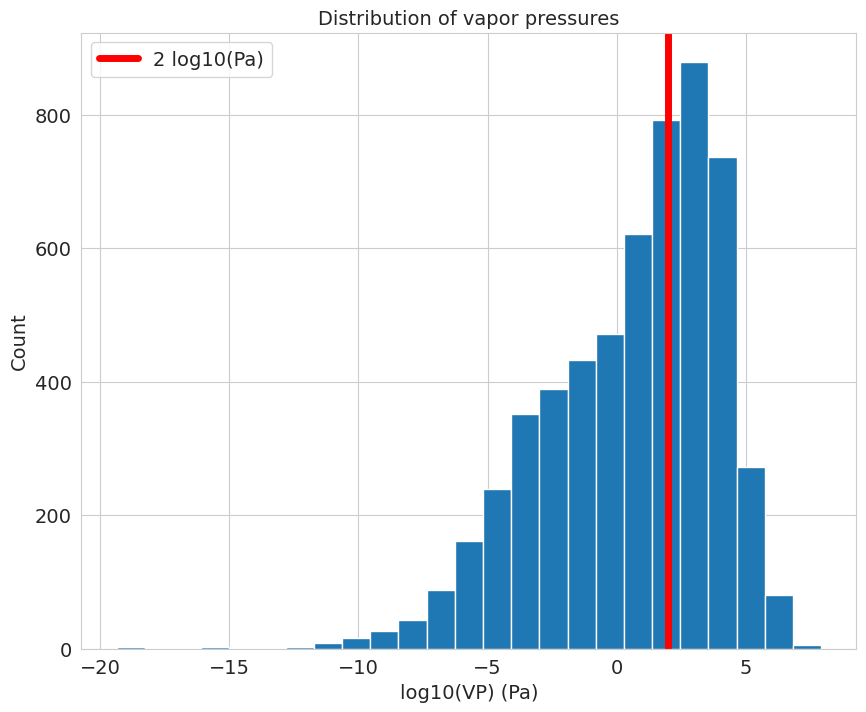

In [ ]:
df_combined
#histogram of vapor pressures
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
#plot
fig,ax = plt.subplots(figsize=(10,8))
#plot measured
ax.hist(df_combined['log10_VP_Pa'],bins=25)
ax.set_xlabel('log10(VP) (Pa)',fontsize=14)
ax.set_ylabel('Count',fontsize=14)
#bigger ticksdf_combined_desc_unqiueze=14)
#add vertical line at x = 2
ax.axvline(x=2,color='red',linestyle='-',label='2 log10(Pa)',linewidth=5)
ax.legend(fontsize=14)
#add titel
ax.set_title('Distribution of vapor pressures',fontsize=14)
plt.show()


Does not look so low to me...

                                    standardized_smiles  log10_VP_Pa  \
1834  O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...   -11.356599   
4462  O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...    -5.493081   

                         inchikey source  
1834  UZGLIIJVICEWHF-UHFFFAOYSA-N  OPERA  
4462  UZGLIIJVICEWHF-UHFFFAOYSA-N  REACH  


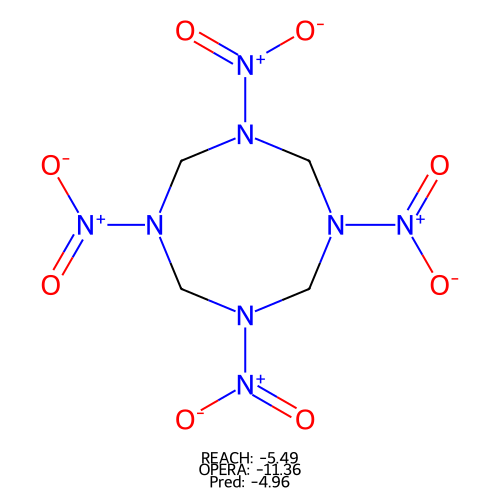

In [ ]:
print(df_combined[df_combined['inchikey']== inchikeys[4]])
#our first contradicting one, interesting! Let draw it
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles[4:5]]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=1, subImgSize=(500, 500), legends=[f'REACH: -5.49\n{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[4:5],ground_truths[4:5],preds[4:5])])
img

Note that here, the value in reach is much closter to our predicted value. Lets look at the source

In [ ]:
df_opera_298K[df_opera_298K['inchikey']== inchikeys[4]]

SMILES  VP log mmHg  \
1834  O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...   -13.481501   

       VP logPa                                standardized_smiles  \
1834 -11.356599  O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...   

                         inchikey  
1834  UZGLIIJVICEWHF-UHFFFAOYSA-N

Reach value comes from estimation: The estimated value of Vapour Pressure, using EPIWIN Program, was found to be 2.41 x 10-8 mm Hg ( 3.21x 10-6 Pa) at 25°C. OPERA value I'm not sure, the compound is in the linked source but vapor pressure not mentioned: https://www.sciencedirect.com/science/article/pii/S0021967303015565?via%3Dihub#TBL2

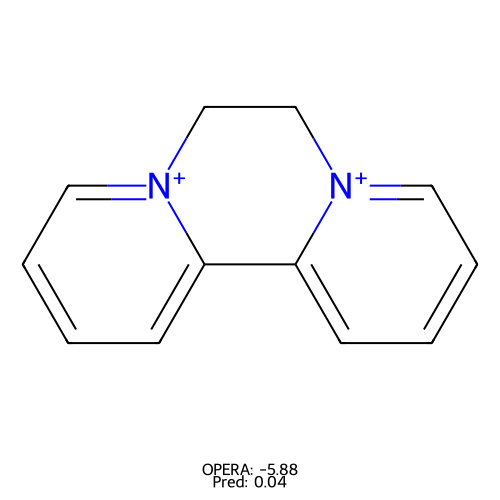

In [ ]:
df_combined[df_combined['inchikey']== inchikeys[6]]
#draw
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles[6:7]]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=1, subImgSize=(500, 500), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[6:7],ground_truths[6:7],preds[6:7])])
img
# df_opera_298K[df_opera_298K['inchikey']== inchikeys[6]]

can't find the value in cited literature. lot of research by weber on environmental stuff and diquat, but have not seen a value for vapor pressure. Saw other paper where it was just set to 0. I think the 8.0 is also a bit suspicous. But then again, I think the error is not huge considering the weirdness of the molecule

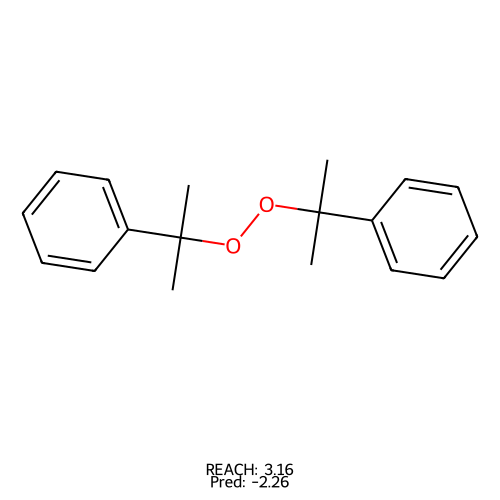

In [ ]:
df_combined[df_combined['inchikey']== inchikeys[7]]
# #draw
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles[7:8]]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=1, subImgSize=(500, 500), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[7:8],ground_truths[7:8],preds[7:8])])
img

Original entry: https://echa.europa.eu/nl/registration-dossier/-/registered-dossier/14703/4/7
"The vapour pressure was found to be less than 0.1 mbar in the temperature range of 60–80 °C. Vapour pressures measured at  90 °C and 100 °C were 0.1 mbar and 0.29 mbar, respectively. Vapour pressures interpolated at 110 °C and 120 °C were 0.71 mbar and 1.46 mbar, respectively. For risk assessment a vapour pressure of 0.001 Pa at 25 °C is considered. '

In [ ]:
df_reach_standardized_uncurated[df_reach_standardized_uncurated['standardized_smiles']== smiles[7]]

#name      cas  \
2172  bis(Ô±,Ô±-dimethylbenzyl) peroxide  80-43-3   

                                    iupacName  P (upperQualifier)  \
2172  1,1'-(dioxydipropane-2,2-diyl)dibenzene                 NaN   

      P (upperValue)  P (lowerQualifier)  P (lowerValue) P (unit)  \
2172             NaN                 NaN            10.9    mm Hg   

      T (upperQualifier)  T (upperValue)  T (lowerQualifier)  T (lowerValue)  \
2172                 NaN             NaN                 NaN            25.0   

     T (unit)      VP_Pa  Temperature_K                            SMILES  \
2172        C  1453.2098         298.15  CC(C)(OOC(C)(C)c1ccccc1)c2ccccc2   

                   standardized_smiles  log10_VP_Pa  NumHeavyAtoms  
2172  CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1     3.162328             20

In [ ]:
df_combined[df_combined['inchikey']== inchikeys[8]]
#draw
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles[8:9]]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=1, subImgSize=(500, 500), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[8:9],ground_truths[8:9],preds[8:9])])
img
# #show in OPERA
df_opera_298K[df_opera_298K['inchikey']== inchikeys[8]]

SMILES  VP log mmHg  \
2241  COC(=O)c1ccccc1CS(=O)(=O)NC(=O)Nc1nc(OC)cc(OC)n1   -13.677799   

       VP logPa                               standardized_smiles  \
2241 -11.552897  COC(=O)c1ccccc1CS(=O)(=O)NC(=O)Nc1nc(OC)cc(OC)n1   

                         inchikey  
2241  XMQFTWRPUQYINF-UHFFFAOYSA-N

In [ ]:
np.log10(2.8E-9 * 1000)
#original source: The Pesticide Manual: Incorporating the Agrochemicals Handbook not available, no way to check. No reason to remove

-5.552841968657781

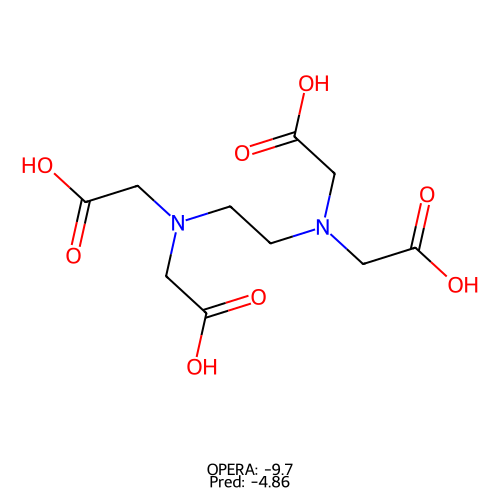

In [ ]:
df_combined[df_combined['inchikey']== inchikeys[9]]
#draw
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles[9:10]]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=1, subImgSize=(500, 500), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[9:10],ground_truths[9:10],preds[9:10])])
img

protonation state issue? https://echa.europa.eu/nl/registration-dossier/-/registered-dossier/7894 "The vapour pressure is estimated to be very low for partically ionic substances. Therefore a determination was not conducted."

In [ ]:
df_combined[df_combined['inchikey']== inchikeys[10]]
#agreement without exact same value for two sources, and a relatively weird molecule, so OK

standardized_smiles  log10_VP_Pa  \
1039  FC(F)(F)C(F)(F)C(F)(F)C(F)(F)N(C(F)(F)C(F)(F)C...     1.866521   
3414  FC(F)(F)C(F)(F)C(F)(F)C(F)(F)N(C(F)(F)C(F)(F)C...     1.832000   

                         inchikey      source  
1039  RVZRBWKZFJCCIB-UHFFFAOYSA-N       OPERA  
3414  RVZRBWKZFJCCIB-UHFFFAOYSA-N  Naef_Acree

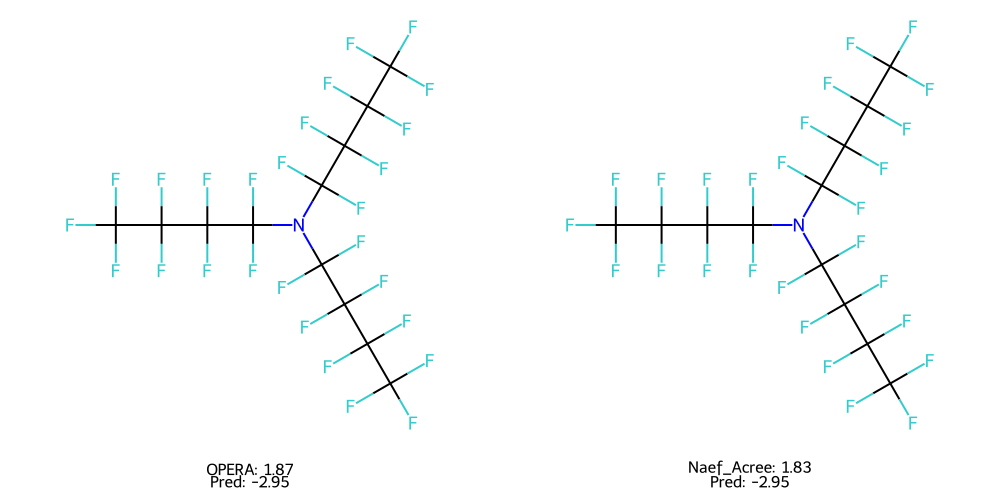

In [ ]:
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles[10:12]]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=2, subImgSize=(500, 500), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[10:12],ground_truths[10:12],preds[10:12])])
img

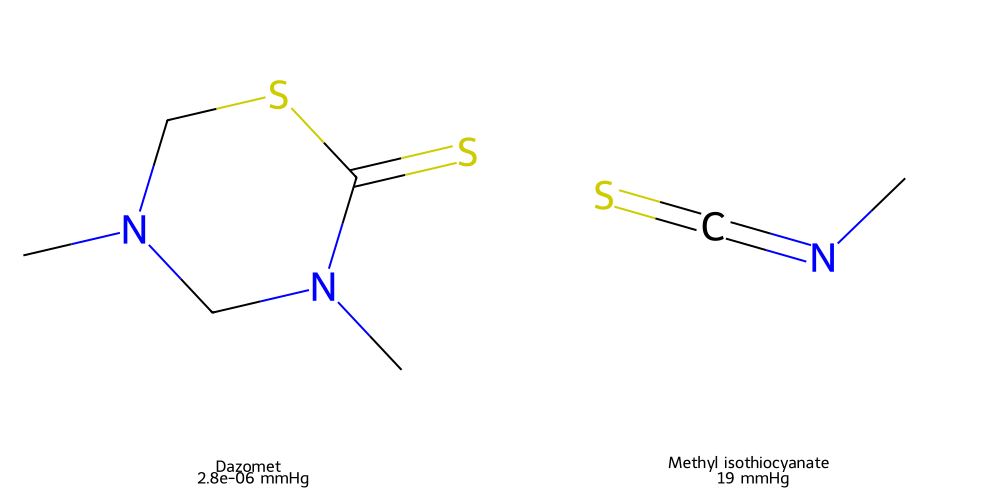

In [ ]:
df_combined[df_combined['inchikey']== inchikeys[12]]
#draw
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles[12:13]]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=1, subImgSize=(500, 500), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[12:13],ground_truths[12:13],preds[12:13])])
img
#add to drawing: Methyl isothiocyanate (S=C=NC)
mols_to_draw.append(Chem.MolFromSmiles('S=C=NC'))
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=2, subImgSize=(500, 500), legends=[f'Dazomet \n {2.8E-6} mmHg','Methyl isothiocyanate \n 19 mmHg'])
img


"Dazomet is non-volatile degrades very rapidly to MITC in soil". Vp of 2.8E-6 mmHg. So probably a true mistake of the model (or degraded product measured ;) )

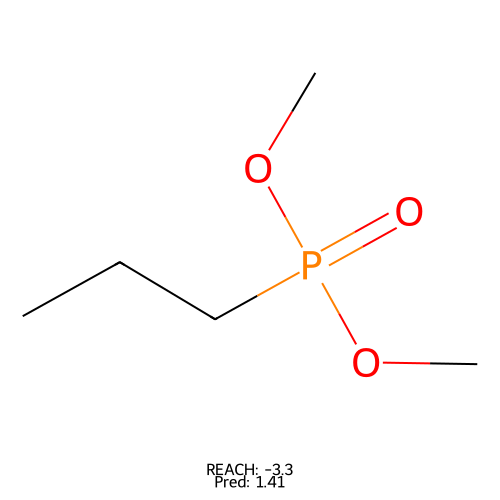

In [ ]:
df_combined[df_combined['inchikey']== inchikeys[13]]
#draw
mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles[13:14]]
img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=1, subImgSize=(500, 500), legends=[f'{s}: {round(g,2)}\nPred: {round(p,2)}' for s,g,p in zip(sources[13:14],ground_truths[13:14],preds[13:14])])
img

In [ ]:
df_reach_standardized_uncurated[df_reach_standardized_uncurated['standardized_smiles']== smiles[13]]
#interesting! lets look at the entry in REACH

#name         cas                   iupacName  \
2786  dimethyl propylphosphonate  18755-43-6  dimethyl propylphosphonate   
2787  dimethyl propylphosphonate  18755-43-6  dimethyl propylphosphonate   
2788  dimethyl propylphosphonate  18755-43-6  dimethyl propylphosphonate   
2789  dimethyl propylphosphonate  18755-43-6  dimethyl propylphosphonate   

      P (upperQualifier)  P (upperValue)  P (lowerQualifier)  P (lowerValue)  \
2786                 NaN             NaN                 NaN         4.00000   
2787                 NaN             NaN                 NaN         1.30000   
2788                 NaN             NaN                 NaN         0.00022   
2789                 NaN             NaN                 NaN         0.00050   

     P (unit)  T (upperQualifier)  T (upperValue)  T (lowerQualifier)  \
2786     mBar                 NaN             NaN                 NaN   
2787      hPa                 NaN             NaN                 NaN   
2788       Pa                 NaN             NaN                 NaN   
2789       Pa                 NaN             NaN                 NaN   

      T (lowerValue) T (unit)      VP_Pa  Temperature_K            SMILES  \
2786            20.0        C  400.00000         293.15  CCC[P](=O)(OC)OC   
2787            20.0        C  130.00000         293.15  CCC[P](=O)(OC)OC   
2788            20.0        C    0.00022         293.15  CCC[P](=O)(OC)OC   
2789            25.0        C    0.00050         298.15  CCC[P](=O)(OC)OC   

     standardized_smiles  log10_VP_Pa  NumHeavyAtoms  
2786      CCCP(=O)(OC)OC     2.602060              9  
2787      CCCP(=O)(OC)OC     2.113943              9  
2788      CCCP(=O)(OC)OC    -3.657577              9  
2789      CCCP(=O)(OC)OC    -3.301030              9

reliable with restrictions: https://echa.europa.eu/nl/registration-dossier/-/registered-dossier/13875/4/7
measured using static method ("suitable for very low vapor pressures, according to the guidelines OECD"). measurements between 338 and 357K, extrapolation to lower

In [ ]:
print(np.log10(np.exp(-13959 / 298.15 + 39.211)))
#so if equation is correct, the used pressure is correct

-3.303988823194033


In [ ]:
df_combined[df_combined['inchikey']== inchikeys[13]]

standardized_smiles  log10_VP_Pa                     inchikey source
5160      CCCP(=O)(OC)OC     -3.30103  YWDFOLFVOVCBIU-UHFFFAOYSA-N  REACH

In [ ]:
df_combined

standardized_smiles  log10_VP_Pa  \
0                              CC(O)C(=O)O     1.035002   
1                 O=C(O)c1c(Cl)ccc(Cl)c1Cl    -1.134698   
2         c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34    -6.135498   
3     COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C    -4.594099   
4                     O=C(O)c1cccc(Cl)c1Cl    -1.517198   
...                                    ...          ...   
5621                                   FCF     6.230704   
5622                                   C#C     5.843183   
5623                                  C=CF     6.232996   
5624                                FC(F)F     6.672597   
5625                               C=C(F)F     6.602060   

                         inchikey source  
0     JVTAAEKCZFNVCJ-UHFFFAOYSA-N  OPERA  
1     XZIDTOHMJBOSOX-UHFFFAOYSA-N  OPERA  
2     FMMWHPNWAFZXNH-UHFFFAOYSA-N  OPERA  
3     ZPUCINDJVBIVPJ-UHFFFAOYSA-N  OPERA  
4     QAOJBHRZQQDFHA-UHFFFAOYSA-N  OPERA  
...                           ...    ...  
5621  RWRIWBAIICGTTQ-UHFFFAOYSA-N  REACH  
5622  HSFWRNGVRCDJHI-UHFFFAOYSA-N  REACH  
5623  XUCNUKMRBVNAPB-UHFFFAOYSA-N  REACH  
5624  XPDWGBQVDMORPB-UHFFFAOYSA-N  REACH  
5625  BQCIDUSAKPWEOX-UHFFFAOYSA-N  REACH  

[5626 rows x 4 columns]

In [ ]:
#####################################

In [ ]:
#test: remove these outliers
df_combined_desc_unqiue

standardized_smiles  log10_VP_Pa                     inchikey  \
0                    CC(O)C(=O)O     1.035002  JVTAAEKCZFNVCJ-UHFFFAOYSA-N   
2379             O=[N+]([O-])CBr     2.616301  DNPRVXJGNANVCZ-UHFFFAOYSA-N   
2380                 C=C(C)C(C)C     4.526302  OWWIWYDDISJUMY-UHFFFAOYSA-N   
3890                CC(=O)C(C)CO     1.478603  VVSRECWZBBJOTG-UHFFFAOYSA-N   
2382                 CC(C)=C(C)C     4.225303  WGLLSSPDPJPLOR-UHFFFAOYSA-N   
...                          ...          ...                          ...   
5487                     C=CNC=O     1.477121  ZQXSMRAEXCEDJD-UHFFFAOYSA-N   
5488                C=CN1CCCC1=O     1.181844  WHNWPMSKXPGLAX-UHFFFAOYSA-N   
5246  Oc1cc(Cl)ccc1Oc1ccc(Cl)cc1    -5.920819  BYNQFCJOHGOKSS-UHFFFAOYSA-N   
5217    O=C1CCCCCCCCCCC(=O)OCCO1    -1.552842  GJJSUPSPZIZYPM-UHFFFAOYSA-N   
5561                       C=COC     5.295347  XJRBAMWJDBPFIM-UHFFFAOYSA-N   

     source  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  \
0     OPERA           9.449074        9.449074           1.185185   
2379  OPERA           9.126736        9.126736           0.159722   
2380  OPERA           3.754630        3.754630           0.657407   
3890  OPERA          10.214769       10.214769           0.032407   
2382  OPERA           2.120370        2.120370           1.425926   
...     ...                ...             ...                ...   
5487  REACH           9.222500        9.222500           0.562500   
5488  REACH          10.660000       10.660000           0.208333   
5246  REACH           9.571747        9.571747           0.002269   
5217  REACH          11.294599       11.294599           0.182275   
5561  REACH           4.305556        4.305556           1.375000   

      MinEStateIndex       qed    MolWt  ...  fr_sulfide  fr_sulfonamd  \
0          -1.231481  0.453936   90.078  ...           0             0   
2379       -0.458333  0.231567  139.936  ...           0             0   
2380        0.657407  0.427202   84.162  ...           0             0   
3890       -0.180556  0.540578  102.133  ...           0             0   
2382        1.425926  0.395123   84.162  ...           0             0   
...              ...       ...      ...  ...         ...           ...   
5487        0.562500  0.451493   71.079  ...           0             0   
5488        0.208333  0.488692  111.144  ...           0             0   
5246        0.002269  0.855980  255.100  ...           0             0   
5217       -0.182275  0.625148  256.342  ...           0             0   
5561        1.375000  0.404628   58.080  ...           0             0   

      fr_sulfone  fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
0              0                  0             0            0            0   
2379           0                  0             0            0            0   
2380           0                  0             0            0            0   
3890           0                  0             0            0            0   
2382           0                  0             0            0            0   
...          ...                ...           ...          ...          ...   
5487           0                  0             0            0            0   
5488           0                  0             0            0            0   
5246           0                  0             0            0            0   
5217           0                  0             0            0            0   
5561           0                  0             0            0            0   

      fr_thiophene  fr_unbrch_alkane  fr_urea  
0                0                 0        0  
2379             0                 0        0  
2380             0                 0        0  
3890             0                 0        0  
2382             0                 0        0  
...            ...               ...      ...  
5487             0                 0        0  
5488             0       